# From Lab  to Lecture: 

## Analyzing the Connection Between Professors’ Research and Course Content​ they teach 👩‍🏫

**Authors**:
- Erik Wold Riise, s194633​
- Lukas Rasocha, s233498​
- Zou Yong Nan Klaassen, s230351

<center><img src="./assets/intro.png" alt="drawing" width="850"/></center>


*Image Prompt: minimalistic network visualization with two nodes: one representing a professor and the other a course they teach, connected by a single edge*


### Project Overview ✍️

This project investigates the alignment between professors’ research areas and the courses they teach through the angle of network analysis and natural language processing (NLP).
We plan to construct a bipartite graph of professors and courses, and analyze the structural and thematic patterns in teaching and research connections.

The central research question of the project is:
**1)_"How well do professors’ research areas align with the content and objectives of the courses they teach, and how does this alignment vary across disciplines?"_**

To complement this, we also examine:
**2) _"Does the alignment between professors’ research and the courses they teach influence student satisfaction and performance (grades)?"_**

And lastly a more practical question:
**3) _"In a situation where a professor quits, how can we find a suitable replacement based on the research areas of the professor and the courses they teach?_"**


*If a professor has a high degree does it have something to do with the average grade/feedback (because there could be a bit busy*

*Compare departments?*

Using NLP techniques, we analyze course descriptions and research topics to measure alignment, and we relate these findings to course evaluations and grades.

By this we hope to shed light on how expertise and teaching intersect, and how does that impact educational outcomes in a broader sense.

### Data Overview 📊

We collected data from 3 separate sources. The first source is the **DTU course base** from which we gathered information about the courses and the professors teaching them (including the grades, ratings, descriptions, prerequisites, etc.). The second source is the **DTU orbit database**, which contains information about the professors and their research from which we scraped all the necessary fields for each professor (research fingerprint, interests, etc.). The third source is a platform called **scholia**, which provides an API that we used to get additional information about the professors and their research (such as the topics of their research papers).

## Imports

In [ ]:
import networkx as nx
from networkx import bipartite_layout
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import circlify
import requests
import random
import os
import re
import json
import statistics
import seaborn as sns
from tqdm import tqdm
from bs4 import BeautifulSoup

# from scholia import query as scholia_query
from SPARQLWrapper import SPARQLWrapper, JSON

## Style settings

In [ ]:
# Colors for plots (DTU Colours)
RED = "#990000"
BLUE = "#2F3EEA"
GREEN = "#1FD082"
NAVY = "#030F4F"
YELLOW = "#F6D04D"
ORANGE = "#FC7634"
SALMON = "#E83F48"
PURPLE = "#79238E"
DARKGREEN = "#008835"

plt.style.use("default")
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({"font.size": 12})

## Data Aquisition & Preparation

### Load Course Data

In [ ]:
file_path = "data/course_df.csv"
course_df = pd.read_csv(file_path)

### DTU Orbit Scraper class + Scholia API

placeholder for the description of the code cell below

In [ ]:
class DTUOrbitScraper:
    def __init__(self):
        self.base_url = "https://orbit.dtu.dk/en/persons/"
        self.endpoint_url = "https://query.wikidata.org/sparql"

    def search_person(self, name):
        """Search for the person and get the URL to their profile."""
        search_url = (
            f"{self.base_url}?search={name.replace(' ', '+')}&isCopyPasteSearch=false"
        )
        response = requests.get(search_url)

        if response.status_code != 200:
            raise Exception("Failed to fetch search results")

        soup = BeautifulSoup(response.text, "html.parser")
        # Find the first profile link (assuming it's the first result)
        profile_link = soup.find("h3", class_="title").find("a", href=True)

        if profile_link:
            return profile_link["href"]
        else:
            raise Exception("Profile link not found")

    def get_topic_info(self, topic_url):
        """Scrape the description for a topic from its Wikidata page."""
        response = requests.get(topic_url)
        if response.status_code != 200:
            return "Description not found"

        soup = BeautifulSoup(response.text, "html.parser")
        description = soup.find(
            "div", class_="wikibase-entitytermsview-heading-description"
        )
        return description.text.strip() if description else "Description not found"

    def get_scholia_topics(self, qs):
        """Get topics and scores from Scholia using SPARQL."""
        query = f"""PREFIX target: <http://www.wikidata.org/entity/{qs}>
        SELECT ?score ?topic ?topicLabel
        WITH {{
            SELECT (SUM(?score_) AS ?score) ?topic WHERE {{
                {{ target: wdt:P101 ?topic . BIND(20 AS ?score_) }}
                UNION {{ SELECT (3 AS ?score_) ?topic WHERE {{ ?work wdt:P50 target: ; wdt:P921 ?topic . }} }}
                UNION {{ SELECT (1 AS ?score_) ?topic WHERE {{ ?work wdt:P50 target: . ?citing_work wdt:P2860 ?work . ?citing_work wdt:P921 ?topic . }} }}
            }} GROUP BY ?topic
        }} AS %results 
        WHERE {{
            INCLUDE %results
            SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
        }}
        ORDER BY DESC(?score)
        LIMIT 200"""

        sparql = SPARQLWrapper(self.endpoint_url)
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()

        topics = []

        for result in results["results"]["bindings"]:
            topic_url = result["topic"]["value"]
            topic_label = result["topicLabel"]["value"]
            score = int(result["score"]["value"])
            # info = self.get_topic_info(topic_url)
            # topics[topic_label] = {"score": score, "info": info}
            topics.append(
                {"topic": topic_label, "score": score, "topic_url": topic_url}
            )
        return topics

    def get_profile_info(self, name):
        """Retrieve profile information given a person's name."""
        full_profile_url = self.search_person(name)
        response = requests.get(full_profile_url)

        if response.status_code != 200:
            raise Exception("Failed to fetch profile page")

        soup = BeautifulSoup(response.text, "html.parser")

        # Extract profile information
        profile_info = {}

        # Get Profile Description
        profile_header = soup.find("h3", string="Profile")
        profile_section = profile_header.find_next("p") if profile_header else None
        profile_info["Profile_desc"] = (
            profile_section.get_text(strip=True) if profile_section else "None"
        )

        # Get Keywords
        keywords_section = soup.find("div", class_="keyword-group")
        if keywords_section:
            keywords = [
                keyword.get_text(strip=True)
                for keyword in keywords_section.find_all(
                    "li", class_="userdefined-keyword"
                )
            ]
            profile_info["Keywords"] = keywords
        else:
            profile_info["Keywords"] = []

        # Get Fingerprint (Concepts, Thesauri, Values)
        fingerprints = []
        fingerprint_section = soup.find("div", class_="person-top-concepts")
        if fingerprint_section:
            fingerprint_items = fingerprint_section.find_all(
                "li", class_="concept-badge-large-container"
            )
            for item in fingerprint_items:
                concept = (
                    item.find("span", class_="concept").get_text(strip=True)
                    if item.find("span", class_="concept")
                    else "N/A"
                )
                thesauri = (
                    item.find("span", class_="thesauri").get_text(strip=True)
                    if item.find("span", class_="thesauri")
                    else "N/A"
                )
                value = (
                    item.find("span", class_="value sr-only").get_text(strip=True)
                    if item.find("span", class_="value sr-only")
                    else "N/A"
                )
                fingerprints.append(
                    {"Concept": concept, "Thesauri": thesauri, "Value": value}
                )
        profile_info["Fingerprint"] = fingerprints

        # Extract ORCID
        orcid_section = soup.find(
            "div", class_="rendering_person_personorcidrendererportal"
        )
        if orcid_section:
            orcid_link = orcid_section.find("a", href=True)
            profile_info["ORCID"] = orcid_link["href"] if orcid_link else "Not found"
            if orcid_link:
                orcid_id = orcid_link["href"].split("/")[-1]
                profile_info["QS"] = scholia_query.orcid_to_qs(orcid_id)
                # Retrieve Scholia topics if QS exists
                if len(profile_info["QS"]) == 1:
                    profile_info["scholia_topics"] = self.get_scholia_topics(
                        profile_info["QS"][0]
                    )
                else:
                    profile_info["scholia_topics"] = {}
        else:
            profile_info["ORCID"] = "Not found"
            profile_info["QS"] = "Not found"
            profile_info["scholia_topics"] = {}

        return profile_info

### Scrape Professors information

placeholder for the description of the code cell below

In [ ]:
scraper = DTUOrbitScraper()

professor_columns = [
    "MAIN_RESPONSIBLE_NAME",
    "CO_RESPONSIBLE_1_NAME",
    "CO_RESPONSIBLE_2_NAME",
    "CO_RESPONSIBLE_3_NAME",
    "CO_RESPONSIBLE_4_NAME",
]


def extract_professors(course_df, professor_columns):
    professors = set()
    for col in professor_columns:
        professors.update(course_df[col].unique())
    return {prof for prof in professors if prof != "NO_DATA"}


def scrape_professor_data(professors, output_file):
    if os.path.exists(output_file):
        print(f"File {output_file} already exists. Skipping scraping.")
        return

    all_data = {}

    for professor in tqdm(professors, desc="Scraping Professors"):
        if professor in all_data:
            print(f"Skipping {professor} as it already exists in the JSON file.")
            continue

        try:
            profile_info = scraper.get_profile_info(professor)
            all_data[professor] = profile_info  # Add to dictionary
        except Exception as e:
            print(f"Failed to scrape data for {professor}: {str(e)}")
            continue

    with open(output_file, "w") as f:
        json.dump(all_data, f, indent=4)

    print(f"Saved all professor data to {output_file}")


output_file = "data/all_professors.json"
professors = extract_professors(course_df, professor_columns)
scrape_professor_data(professors, output_file)

File data/all_professors.json already exists. Skipping scraping.


### Load Professors data

In [6]:
with open("data/all_professors.json", "r") as f:
    professors_data = json.load(f)

## Exploratory Data Analysis of the Entire Collected datasets

Available information from the courses dataset:
['COURSE', 'NAME', 'DANISH_NAME', 'LANGUAGE', 'ECTS_POINTS', 'COURSE_TYPE', 'STUDENTS_PER_SEMESTER', 'SEMESTER_PERIOD', 'EXAM_TYPE', 'ASSIGNMENTS', 'TIME_OF_WEEK', 'LAST_UPDATED', 'GRADE_12', 'GRADE_10', 'GRADE_7', 'GRADE_4', 'GRADE_02', 'GRADE_00', 'GRADE_MINUS_3', 'PASSED', 'FAILED', 'ABSENT', 'AVERAGE_GRADE', 'TOTAL_STUDENTS', 'PERCENT_PASSED', 'PERCENT_FAILED', 'PERCENT_ABSENT', 'RATING_TIER', 'RATING_AVERAGE_SCORE', 'RATING_VOTES', 'LEARNING_TIER', 'LEARNING_AVERAGE_SCORE', 'LEARNING_VOTES', 'MOTIVATION_TIER', 'MOTIVATION_AVERAGE_SCORE', 'MOTIVATION_VOTES', 'FEEDBACK_TIER', 'FEEDBACK_AVERAGE_SCORE', 'FEEDBACK_VOTES', 'WORKLOAD_TIER', 'WORKLOAD_AVERAGE_SCORE', 'WORKLOAD_VOTES', 'WORKLOAD_4_STAR', 'WORKLOAD_5_STAR', 'MAIN_RESPONSIBLE_NAME', 'MAIN_RESPONSIBLE_PIC', 'CO_RESPONSIBLE_1_NAME', 'CO_RESPONSIBLE_1_PIC', 'CO_RESPONSIBLE_2_NAME', 'CO_RESPONSIBLE_2_PIC', 'CO_RESPONSIBLE_3_NAME', 'CO_RESPONSIBLE_3_PIC', 'CO_RESPONSIBLE_4_NAME', 'C

Text(0, 0.5, 'Count')

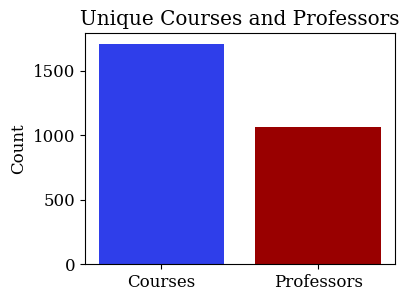

In [ ]:
print("Available information from the courses dataset:")
print(list(course_df.columns))
print("-" * 50)

print("Available information from the professors dataset:")
print(list(professors_data.values())[0].keys())
print("-" * 50)


print(f"Number of unique courses: {course_df['COURSE'].nunique()}")
professors = extract_professors(course_df, professor_columns)
print(f"Number of unique professors: {len(professors)}")

# Barchart one bar is number of unique courses and the other is number of unique professors
plt.figure(figsize=(4, 3))
plt.bar(
    ["Courses", "Professors"],
    [course_df["COURSE"].nunique(), len(professors)],
    color=[BLUE, RED],
)
plt.title("Unique Courses and Professors")
plt.ylabel("Count")

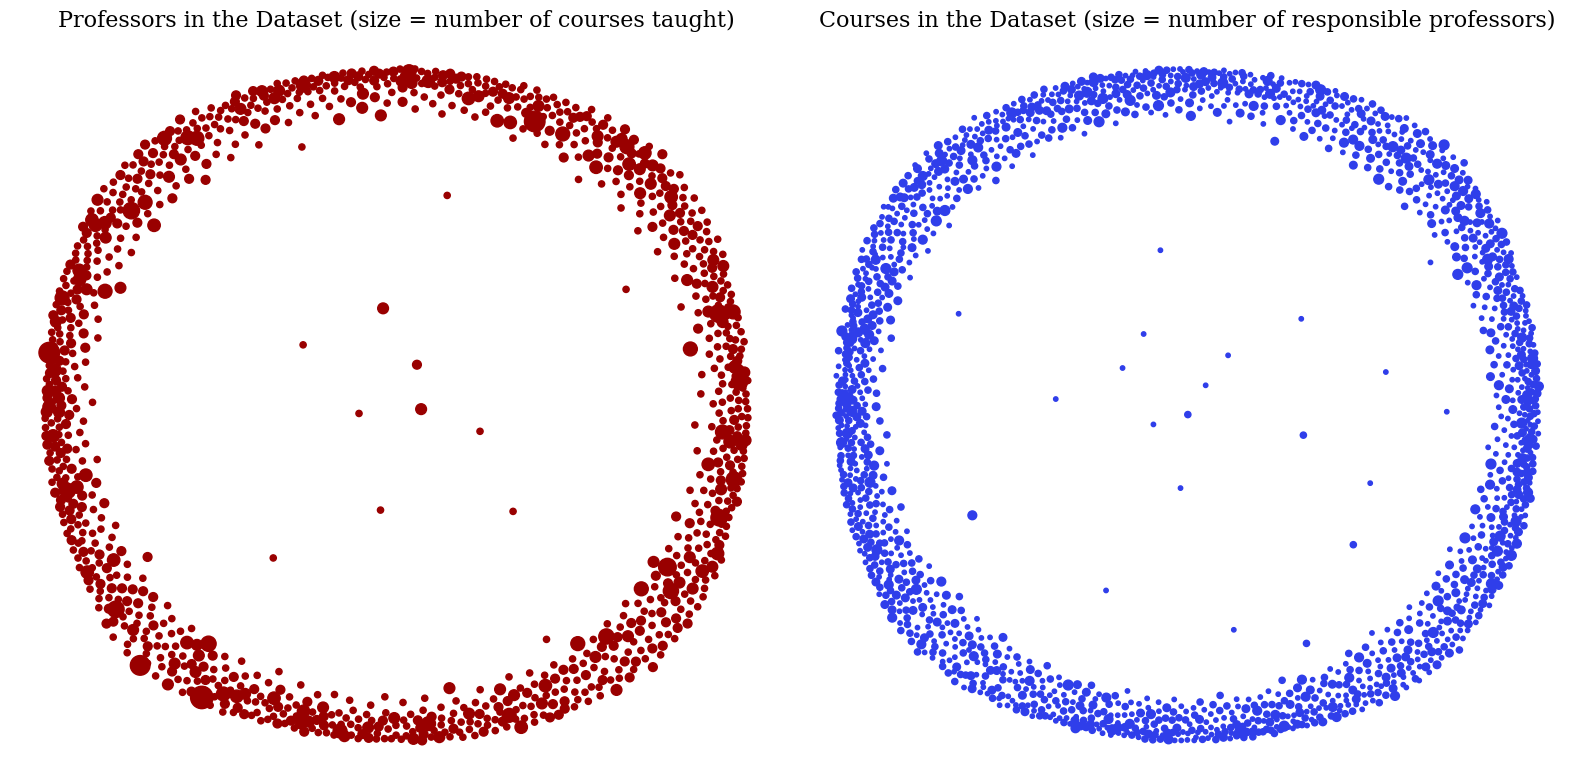

In [ ]:
professors = extract_professors(course_df, professor_columns)

professor_course_counts = {}
for col in professor_columns:
    professor_course_counts.update(course_df[col].value_counts().to_dict())

# Create graph for professors
professor_graph = nx.Graph()
professor_graph.add_nodes_from(professors)
for professor, count in professor_course_counts.items():
    if professor != "NO_DATA":
        professor_graph.nodes[professor]["count"] = count

random_layout_professors = {
    professor: (random.uniform(0, 1), random.uniform(0, 1)) for professor in professors
}

# Calculate the number of responsible names for each course
course_responsible_counts = course_df[professor_columns].apply(
    lambda row: sum(row != "NO_DATA"), axis=1
)

# Create graph for courses
courses = course_df["COURSE"].tolist()
course_graph = nx.Graph()
course_graph.add_nodes_from(courses)
for course, count in zip(courses, course_responsible_counts):
    course_graph.nodes[course]["count"] = count

random_layout_courses = {
    course: (random.uniform(0, 1), random.uniform(0, 1)) for course in courses
}

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot professors graph
plt.sca(axes[0])
pos = nx.spring_layout(professor_graph)
nx.draw_networkx_nodes(
    professor_graph,
    pos,
    random_layout_professors,
    node_size=[
        professor_graph.nodes[prof]["count"] * 20 for prof in professor_graph.nodes
    ],
    node_color=RED,
)
nx.draw_networkx_edges(professor_graph, random_layout_professors, alpha=0.5)
plt.title("Professors in the Dataset (size = number of courses taught)", fontsize=16)
plt.axis("off")

plt.sca(axes[1])
pos = nx.spring_layout(course_graph)
nx.draw_networkx_nodes(
    course_graph,
    pos,
    random_layout_courses,
    node_size=[
        course_graph.nodes[course]["count"] * 10 for course in course_graph.nodes
    ],
    node_color=BLUE,
)
nx.draw_networkx_edges(course_graph, random_layout_courses, alpha=0.5)
plt.title(
    "Courses in the Dataset (size = number of responsible professors)", fontsize=16
)
plt.axis("off")
plt.tight_layout()
plt.show()

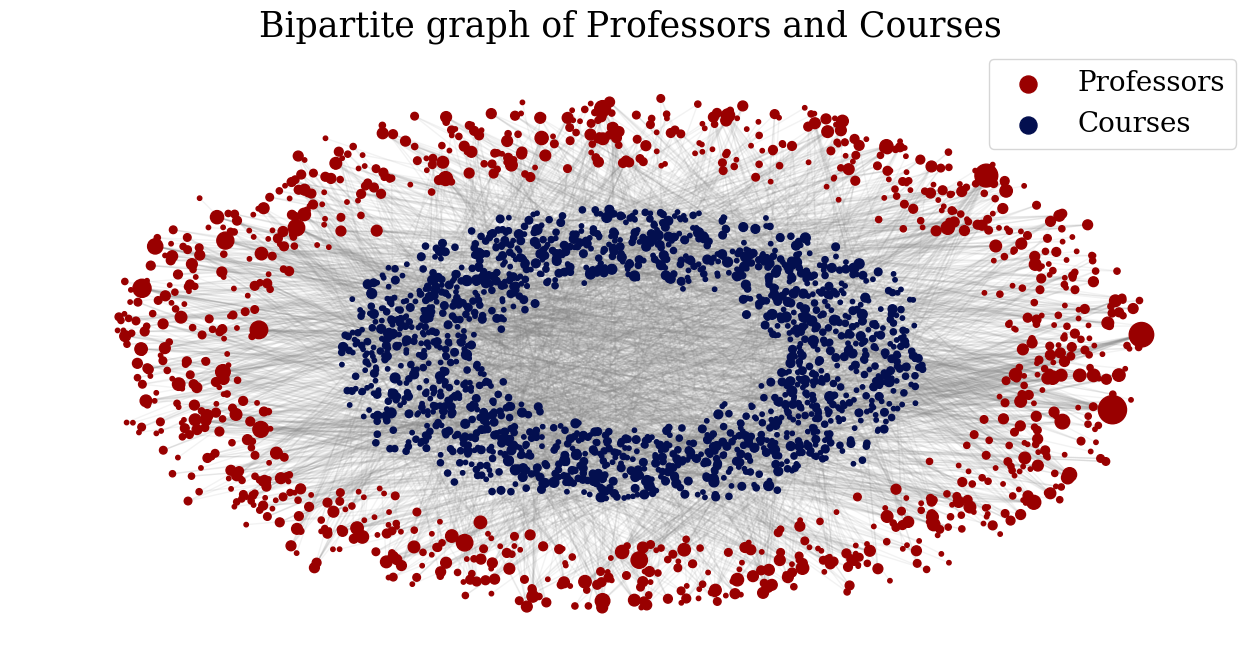

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Extract professors and courses
professors = extract_professors(course_df, professor_columns)
courses = course_df["COURSE"].unique()

# Create the bipartite graph
B = nx.Graph()
B.add_nodes_from(professors, bipartite=0, type="Professor")  # Professors
B.add_nodes_from(courses, bipartite=1, type="Course")  # Courses

# Add edges based on professor-course relationships
for _, row in course_df.iterrows():
    course = row["COURSE"]
    for col in professor_columns:
        professor = row[col]
        if pd.notna(professor) and professor != "NO_DATA":
            B.add_edge(professor, course)


# Add scatter (random perturbation) to circular layout
def add_scatter_to_circle(radius, n_nodes, scatter_factor=0.2):
    """Generate positions for nodes in a rough circle with random scatter."""
    angles = np.linspace(0, 2 * np.pi, n_nodes, endpoint=False)
    positions = [
        (
            radius * np.cos(angle) + np.random.uniform(-scatter_factor, scatter_factor),
            radius * np.sin(angle) + np.random.uniform(-scatter_factor, scatter_factor),
        )
        for angle in angles
    ]
    return positions


# Generate positions for professors (outer "scattered" circle)
professor_positions = {
    prof: pos
    for prof, pos in zip(
        professors,
        add_scatter_to_circle(radius=2, n_nodes=len(professors), scatter_factor=0.3),
    )
}

# Generate positions for courses (inner "scattered" circle)
course_positions = {
    course: pos
    for course, pos in zip(
        courses,
        add_scatter_to_circle(radius=1, n_nodes=len(courses), scatter_factor=0.3),
    )
}

# Combine positions
positions = {**professor_positions, **course_positions}

# Draw the graph
fig, ax = plt.subplots(figsize=(16, 8))

# Plot professors (outer red circle with scatter)
nx.draw_networkx_nodes(
    B,
    pos=professor_positions,
    nodelist=professors,
    node_size=[B.degree(prof) * 10 for prof in professors if prof in B.nodes],
    node_color=RED,
    label="Professors",
)

# Plot courses (inner blue circle with scatter)
nx.draw_networkx_nodes(
    B,
    pos=course_positions,
    nodelist=courses,
    node_size=[B.degree(course) * 10 for course in courses if course in B.nodes],
    node_color=NAVY,
    label="Courses",
)

# Plot edges between professors and courses
edges = [
    (u, v)
    for u, v in B.edges
    if B.nodes[u]["type"] == "Professor" and B.nodes[v]["type"] == "Course"
]
nx.draw_networkx_edges(B, positions, edgelist=edges, alpha=0.1, edge_color="gray")

# Add titles and legend
plt.title("Bipartite graph of Professors and Courses", fontsize=25)
lgnd = plt.legend(scatterpoints=1, loc="upper right", fontsize=20)
for handle in lgnd.legend_handles:
    handle.set_sizes([150.0])
plt.axis("off")
plt.show()

## Visualizations of Course Data

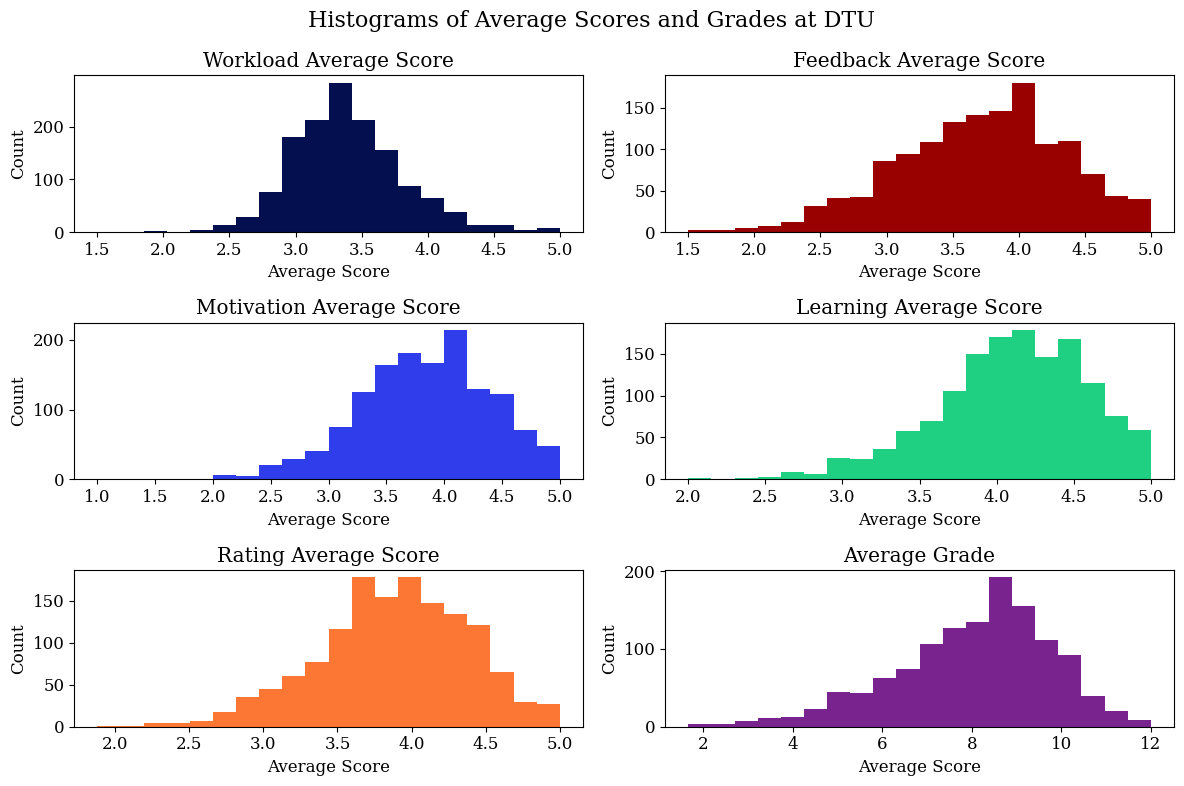

In [ ]:
columns_to_plot = [
    "WORKLOAD_AVERAGE_SCORE",
    "FEEDBACK_AVERAGE_SCORE",
    "MOTIVATION_AVERAGE_SCORE",
    "LEARNING_AVERAGE_SCORE",
    "RATING_AVERAGE_SCORE",
    "AVERAGE_GRADE",
]
COLORS = [RED, BLUE, GREEN, ORANGE, PURPLE, NAVY]
scores = course_df.copy()

scores[columns_to_plot] = (
    scores[columns_to_plot].replace(["No data", "Pass/Fail"], np.nan).astype(float)
)

# Create the 3x2 plot
plt.figure(figsize=(12, 8))
plt.suptitle("Histograms of Average Scores and Grades at DTU", fontsize=16, y=0.98)

# Histograms for the other columns
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(3, 2, i)
    plt.hist(scores[col].dropna(), bins=20, color=COLORS[(i - 2) % len(COLORS)])
    plt.title(f"{col.replace('_', ' ').title()}")
    plt.xlabel("Average Score")
    plt.ylabel("Count")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Visualization of Professors Data

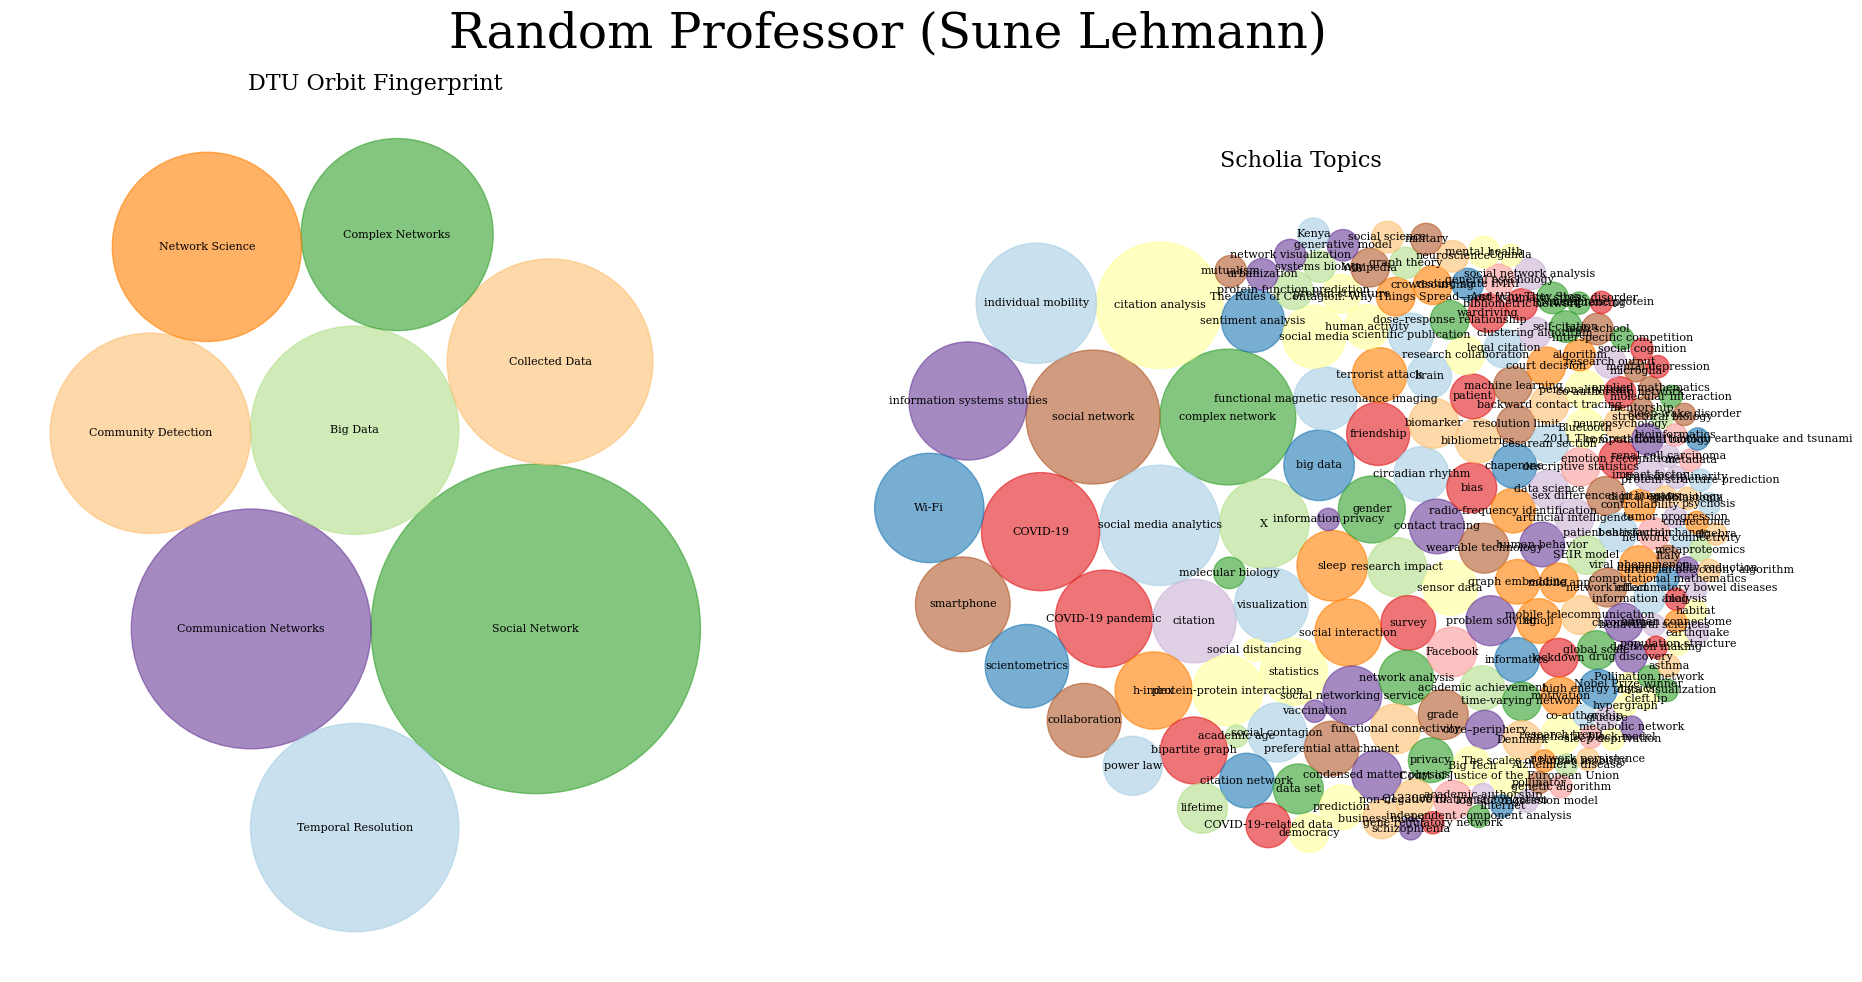

In [ ]:
# Calculate axis limits dynamically for a set of circles
def calculate_limits(circles, padding=0.1):
    x_min = min(circle.x - circle.r for circle in circles)
    x_max = max(circle.x + circle.r for circle in circles)
    y_min = min(circle.y - circle.r for circle in circles)
    y_max = max(circle.y + circle.r for circle in circles)
    return x_min - padding, x_max + padding, y_min - padding, y_max + padding


# Function to map circles back to their correct data
def remap_circles(circles, sizes, concepts):
    # Sort circles by radius (descending)
    sorted_circles = sorted(circles, key=lambda c: c.r, reverse=True)
    # Sort sizes and concepts by size (descending)
    sorted_data = sorted(zip(sizes, concepts), key=lambda x: x[0], reverse=True)
    sorted_sizes, sorted_concepts = zip(*sorted_data)
    return sorted_circles, sorted_concepts


# First dataset
data_1 = professors_data["Sune Lehmann Jørgensen"]["Fingerprint"]
data_2 = professors_data["Sune Lehmann Jørgensen"]["scholia_topics"]

concepts_1 = [item["Concept"] for item in data_1]
sizes_1 = [float(item["Value"].strip("%")) for item in data_1]
concepts_2 = [item["topic"] for item in data_2]
sizes_2 = [item["score"] for item in data_2]

# Calculate circles for both datasets
circles_1 = circlify.circlify(sizes_1, target_enclosure=circlify.Circle(x=0, y=0, r=1))
circles_2 = circlify.circlify(sizes_2, target_enclosure=circlify.Circle(x=0, y=0, r=1))

# Remap circles to correct sizes and concepts
circles_1, concepts_1 = remap_circles(circles_1, sizes_1, concepts_1)
circles_2, concepts_2 = remap_circles(circles_2, sizes_2, concepts_2)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plt.suptitle("Random Professor (Sune Lehmann)", fontsize=35, y=0.98)

# Plot first dataset
axes[0].axis("off")
axes[0].set_aspect("equal")

x_min, x_max, y_min, y_max = calculate_limits(circles_1)
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)

for circle, concept in zip(circles_1, concepts_1):
    x, y, r = circle.x, circle.y, circle.r
    axes[0].add_patch(
        plt.Circle((x, y), r, alpha=0.6, color=plt.cm.Paired(hash(concept) % 12))
    )
    axes[0].text(x, y, concept, fontsize=8, ha="center", va="center")
axes[0].set_title("DTU Orbit Fingerprint", fontsize=16)

# Plot second dataset
axes[1].axis("off")
axes[1].set_aspect("equal")

x_min, x_max, y_min, y_max = calculate_limits(circles_2)
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(y_min, y_max)

for circle, concept in zip(circles_2, concepts_2):
    x, y, r = circle.x, circle.y, circle.r
    axes[1].add_patch(
        plt.Circle((x, y), r, alpha=0.6, color=plt.cm.Paired(hash(concept) % 12))
    )
    axes[1].text(x, y, concept, fontsize=8, ha="center", va="center")
axes[1].set_title("Scholia Topics", fontsize=16)

plt.tight_layout()
plt.show()

## Explaratory Data Analysis of the Network


### Add node attributes to bipartite graph
Professor node attributes:
- Profile_descr: A summary of the professor's academic expertise
- Fingerprint: Keywords summarizing their research focus
- Scholia_topics: Topics associated with their scholarly contributions

Course node attributes:
- COURSE_DESCRIPTION: A short description of the course
- LEARNING_OBJECTIVES: The learning objectives of a course
- COURSE_CONTENT: Details of the topics covered in the course
- AVERAGE_GRADE: Mean average grade achieved by students in a course
- RATING_AVERAGE_SCORE: The mean course rating provided by students
- STUDY_LINES: The academic programs associated with a course

In [ ]:
# Add metadata to nodes
for professor in professors:
    if professor in professors_data:
        # Add professor metadata
        attributes = professors_data[professor]
        B.nodes[professor].update(
            {
                "Profile_desc": attributes.get("Profile_desc", None),
                "Keywords": attributes.get("Keywords", []),
                "Fingerprint": attributes.get("Fingerprint", []),
                "scholia_topics": attributes.get("scholia_topics", []),
            }
        )

for _, row in course_df.iterrows():
    course = row["COURSE"]
    if course in B.nodes:
        B.nodes[course].update(
            {
                "COURSE_DESCRIPTION": row.get("COURSE_DESCRIPTION", ""),
                "LEARNING_OBJECTIVES": row.get("LEARNING_OBJECTIVES", ""),
                "COURSE_CONTENT": row.get("COURSE_CONTENT", ""),
                "AVERAGE_GRADE": row.get("AVERAGE_GRADE", ""),
                "RATING_AVERAGE_SCORE": row.get("RATING_AVERAGE_SCORE", ""),
                "STUDY_LINES": row.get("STUDY_LINES", ""),
            }
        )

# Regular expression to remove HTML tags
html_tag_re = re.compile(r"<[^>]+>")
for node, attributes in B.nodes(data=True):
    studyline_raw = attributes.get("STUDY_LINES", None)
    if studyline_raw:
        # Clean and split on <br />
        studylines = [
            html_tag_re.sub("", part).strip() for part in studyline_raw.split("<br />")
        ]
        B.nodes[node]["STUDY_LINES"] = studylines

unconnected_courses = [course for course in courses if B.degree(course) == 0]
B.remove_nodes_from(unconnected_courses)
courses = [course for course in courses if course not in unconnected_courses]

Subgraph created with 13 nodes and 8 edges.


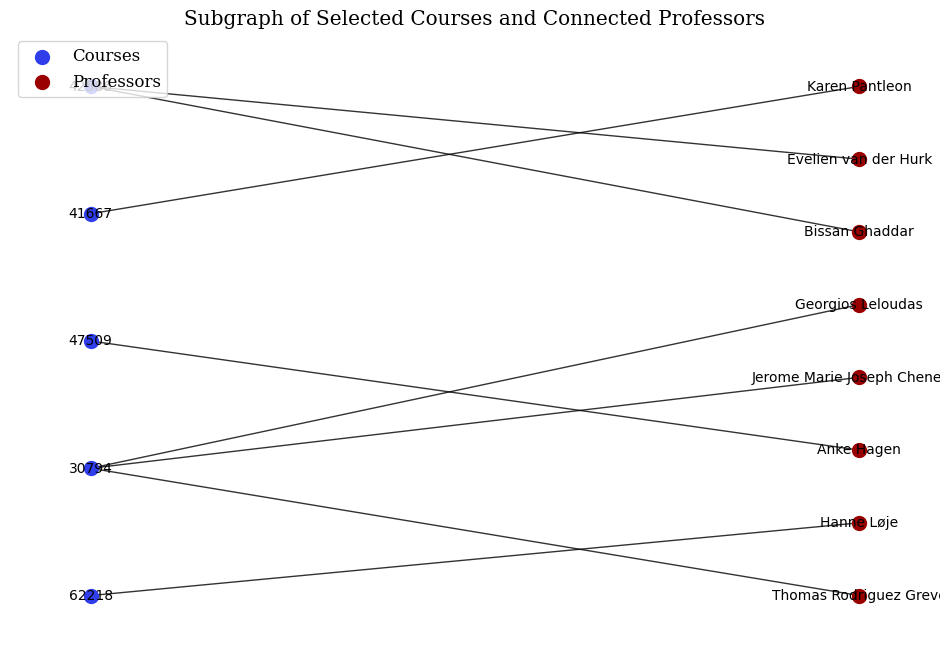

In [ ]:
# Select 5 courses from the courses set
selected_courses = random.sample(list(courses), 5)

# Create a subgraph with the selected courses and their connected professors
subgraph_nodes = set(selected_courses)
for course in selected_courses:
    subgraph_nodes.update(B.neighbors(course))

subgraph = B.subgraph(subgraph_nodes)

# Print the number of nodes and edges in the subgraph
print(
    f"Subgraph created with {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges."
)
# Plot the subgraph
plt.figure(figsize=(12, 8))
pos = bipartite_layout(subgraph, selected_courses)

# Draw the nodes
nx.draw_networkx_nodes(
    subgraph,
    pos,
    nodelist=selected_courses,
    node_color=BLUE,
    node_size=100,
    label="Courses",
)
nx.draw_networkx_nodes(
    subgraph,
    pos,
    nodelist=set(subgraph) - set(selected_courses),
    node_color=RED,
    node_size=100,
    label="Professors",
)

# Draw the edges
nx.draw_networkx_edges(subgraph, pos, alpha=0.8, width=1)

# Add a legend
plt.legend(scatterpoints=1, loc="upper left")

# Draw the labels
nx.draw_networkx_labels(subgraph, pos, font_size=10)

# Add title
plt.title("Subgraph of Selected Courses and Connected Professors")

# Remove axis
plt.axis("off")

# Show the plot
plt.show()

**Figure: Subgraph of Selected Courses and Connected Professors** This subgraph illustrates the relationships between five randomly selected courses from the bipartite network and the professors responsible for teaching them. The visualization highlights the structure of connections by focusing on a subset of the network, this figure provides an intuitive understanding of the interactions without overwhelming the full network's complexity.

### Degree distributions

Investigating degree distributions provides insights into how professors and courses are connected in the bipartite graph.

Professor In-Degree Statistics : Average = 2.96, Median = 2.0, Mode = 1, Min = 1, Max = 41
Course In-Degree Statistics : Average = 1.86, Median = 2.0, Mode = 1, Min = 1, Max = 5
Professor Out-Degree Statistics : Average = 2.96, Median = 2.0, Mode = 1, Min = 1, Max = 41
Course Out-Degree Statistics : Average = 1.86, Median = 2.0, Mode = 1, Min = 1, Max = 5


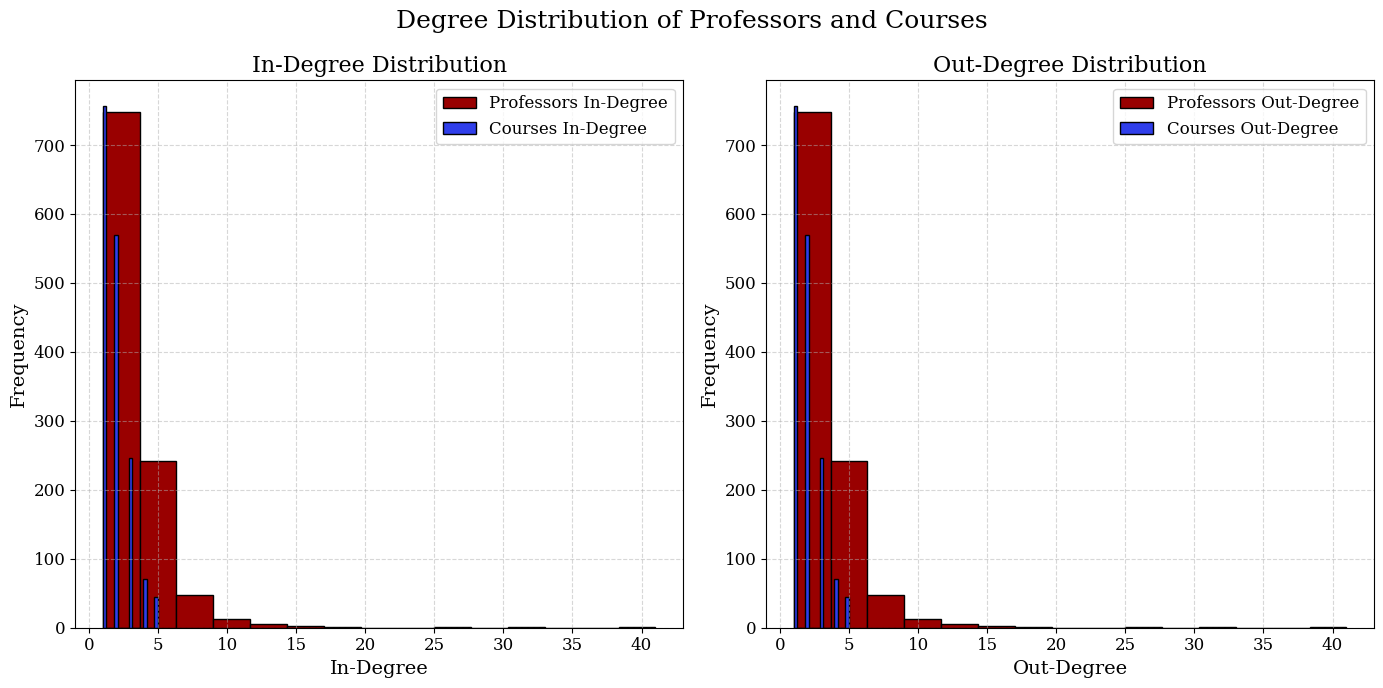

In [ ]:
# Convert the bipartite graph to directed graph
B_directed = B.to_directed()
in_degrees = B_directed.in_degree()
out_degrees = B_directed.out_degree()

professors = {
    node for node, data in B_directed.nodes(data=True) if data["bipartite"] == 0
}
courses = {node for node, data in B_directed.nodes(data=True) if data["bipartite"] == 1}

professor_in_degrees = [in_degrees[professor] for professor in professors]
course_in_degrees = [in_degrees[course] for course in courses]
professor_out_degrees = [out_degrees[professor] for professor in professors]
course_out_degrees = [out_degrees[course] for course in courses]

professor_in_avg = sum(professor_in_degrees) / len(professor_in_degrees)
professor_in_median = statistics.median(professor_in_degrees)
professor_in_mode = statistics.mode(professor_in_degrees)
professor_in_min = min(professor_in_degrees)
professor_in_max = max(professor_in_degrees)

course_in_avg = sum(course_in_degrees) / len(course_in_degrees)
course_in_median = statistics.median(course_in_degrees)
course_in_mode = statistics.mode(course_in_degrees)
course_in_min = min(course_in_degrees)
course_in_max = max(course_in_degrees)

professor_out_avg = sum(professor_out_degrees) / len(professor_out_degrees)
professor_out_median = statistics.median(professor_out_degrees)
professor_out_mode = statistics.mode(professor_out_degrees)
professor_out_min = min(professor_out_degrees)
professor_out_max = max(professor_out_degrees)

course_out_avg = sum(course_out_degrees) / len(course_out_degrees)
course_out_median = statistics.median(course_out_degrees)
course_out_mode = statistics.mode(course_out_degrees)
course_out_min = min(course_out_degrees)
course_out_max = max(course_out_degrees)

print(
    f"{'Professor In-Degree Statistics'} : Average = {professor_in_avg:.2f}, Median = {professor_in_median}, Mode = {professor_in_mode}, Min = {professor_in_min}, Max = {professor_in_max}"
)
print(
    f"{'Course In-Degree Statistics'} : Average = {course_in_avg:.2f}, Median = {course_in_median}, Mode = {course_in_mode}, Min = {course_in_min}, Max = {course_in_max}"
)
print(
    f"{'Professor Out-Degree Statistics'} : Average = {professor_out_avg:.2f}, Median = {professor_out_median}, Mode = {professor_out_mode}, Min = {professor_out_min}, Max = {professor_out_max}"
)
print(
    f"{'Course Out-Degree Statistics'} : Average = {course_out_avg:.2f}, Median = {course_out_median}, Mode = {course_out_mode}, Min = {course_out_min}, Max = {course_out_max}"
)

plt.figure(figsize=(14, 7))

# In-Degree Distribution
plt.subplot(1, 2, 1)
plt.hist(
    professor_in_degrees,
    bins=15,
    color=RED,
    label="Professors In-Degree",
    edgecolor="black",
)
plt.hist(
    course_in_degrees, bins=15, color=BLUE, label="Courses In-Degree", edgecolor="black"
)
plt.legend(loc="upper right", fontsize=12)
plt.title("In-Degree Distribution", fontsize=16)
plt.xlabel("In-Degree", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)

# Out-Degree Distribution
plt.subplot(1, 2, 2)
plt.hist(
    professor_out_degrees,
    bins=15,
    color=RED,
    label="Professors Out-Degree",
    edgecolor="black",
)
plt.hist(
    course_out_degrees,
    bins=15,
    color=BLUE,
    label="Courses Out-Degree",
    edgecolor="black",
)
plt.legend(loc="upper right", fontsize=12)
plt.title("Out-Degree Distribution", fontsize=16)
plt.xlabel("Out-Degree", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)

plt.suptitle("Degree Distribution of Professors and Courses", fontsize=18)
plt.tight_layout()
plt.show()

**Figure: Degree Distribution of Professors and Courses** Most courses are connected to a small number of professors, with an average of 1.86 connections and a median of 2.0. Course degrees are capped at 5. For professors degrees vary widely, ranging from 1 (indicating a professor teaches a single course) to 41. High-degree professors, though fewer, likely represent those with broader academic responsibilities or specialized subjects requiring extensive involvement.

### Random network & Scale-free network comparison

To contextualize the structural features of our bipartite network, we compare it to two well-known graph models: a random Erdős–Rényi (ER) network and a scale-free network. This analysis highlights deviations in degree distribution, density, and connectivity, particularly the Giant Connected Component (GCC).

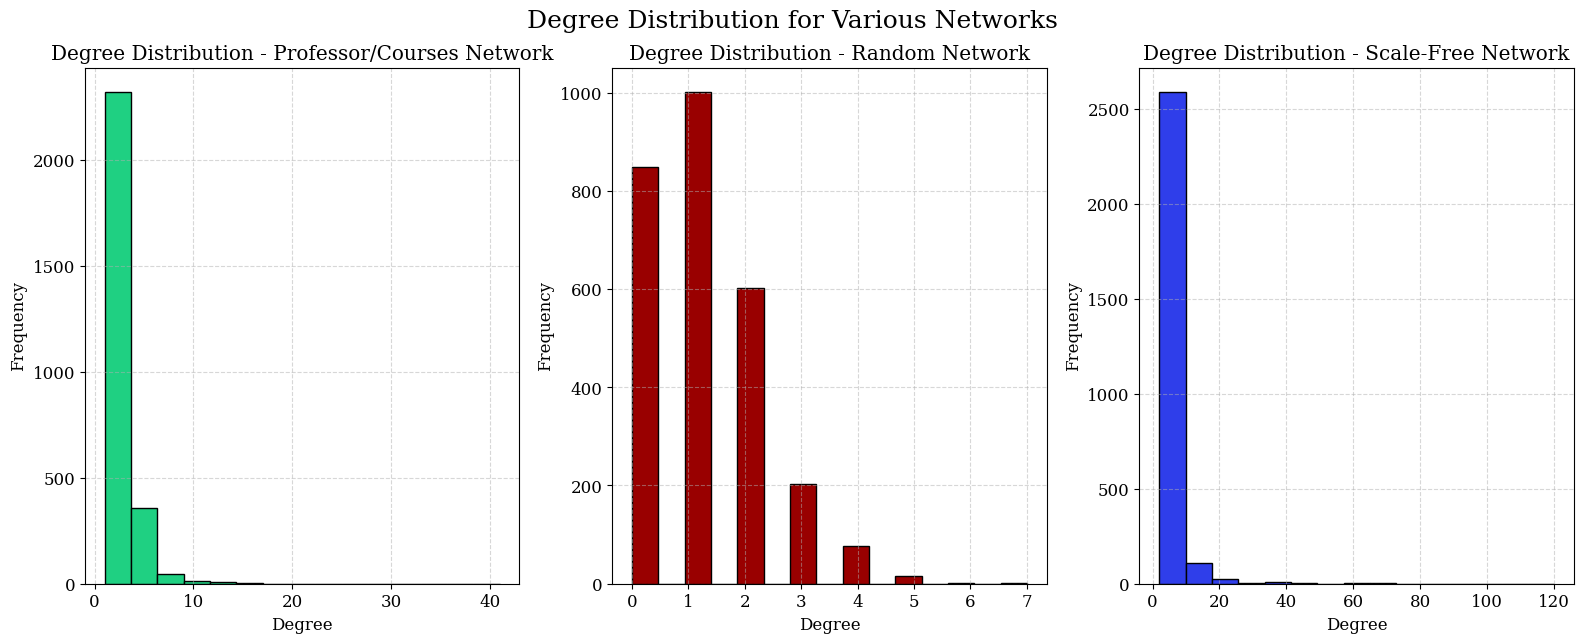

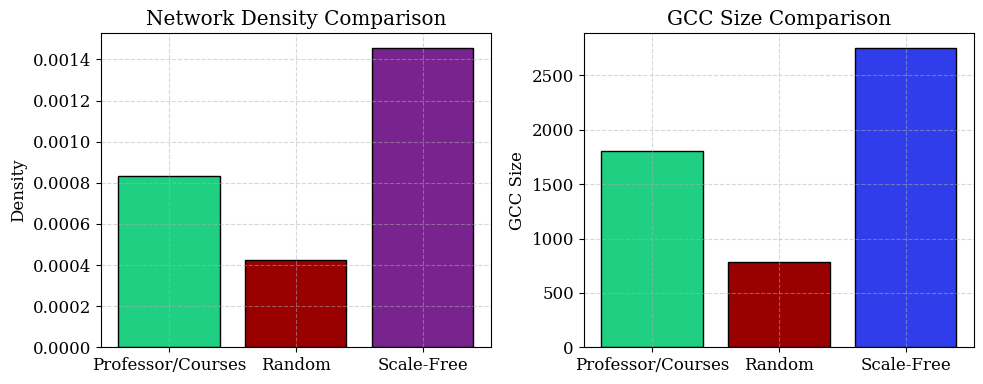

In [ ]:
# Function to calculate the size of the Giant Connected Component (GCC)
def get_gcc_size(graph):
    components = list(nx.connected_components(graph))
    largest_component = max(components, key=len)
    return len(largest_component)


# Generate a random Erdős–Rényi network with the same number of nodes and edges
n = len(B.nodes)  # Number of nodes
m = len(B.edges)  # Number of edges
random_graph = nx.erdos_renyi_graph(n, m / (n * (n - 1)))

# Generate a scale free graph with the same number of nodes
scale_free_graph = nx.barabasi_albert_graph(n, 2)

# Calculate the GCC size for each network
gcc_bipartite_size = get_gcc_size(B)
gcc_random_size = get_gcc_size(random_graph)
gcc_scale_free_size = get_gcc_size(scale_free_graph)

# Calculate the network density for each graph
density_bipartite = nx.density(B)
density_random = nx.density(random_graph)
density_scale_free = nx.density(scale_free_graph)

plt.figure(figsize=(16, 12))

# Degree distribution for Bipartite Network
plt.subplot(2, 3, 1)
plt.hist([d for n, d in B.degree()], bins=15, color=GREEN, edgecolor="black")
plt.title("Degree Distribution - Professor/Courses Network")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)

# Degree distribution for Random Network
plt.subplot(2, 3, 2)
plt.hist([d for n, d in random_graph.degree()], bins=15, color=RED, edgecolor="black")
plt.title("Degree Distribution - Random Network")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)

# Degree distribution for Scale-Free Network
plt.subplot(2, 3, 3)
plt.hist(
    [d for n, d in scale_free_graph.degree()], bins=15, color=BLUE, edgecolor="black"
)
plt.title("Degree Distribution - Scale-Free Network")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)

plt.suptitle("Degree Distribution for Various Networks", fontsize=18)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# style

# Network Density Comparison
axes[0].bar(
    ["Professor/Courses", "Random", "Scale-Free"],
    [density_bipartite, density_random, density_scale_free],
    color=[GREEN, RED, PURPLE],
    edgecolor="black",
)
axes[0].set_title("Network Density Comparison")
axes[0].set_ylabel("Density")
axes[0].tick_params(axis="x", rotation=0)
axes[0].grid(True, linestyle="--", alpha=0.5)

# GCC Size Comparison
axes[1].bar(
    ["Professor/Courses", "Random", "Scale-Free"],
    [gcc_bipartite_size, gcc_random_size, gcc_scale_free_size],
    color=[GREEN, RED, BLUE],
    edgecolor="black",
)
axes[1].set_title("GCC Size Comparison")
axes[1].set_ylabel("GCC Size")
axes[1].tick_params(axis="x", rotation=0)
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

**Figure: Degree Distribution for Various Networks** The degree distribution of the professors/courses network resembles that of a scale-free network. In both networks, most nodes have relatively few connections, while a few nodes have significantly more. This pattern typically indicates that the network is organized in a way that few highly connected nodes play a critical role in maintaining its structure. While the professors/courses network may look similar to a scale-free distribution, there are still deviations.

**Figure: Network Density Comparison** In terms of network density, the professors/courses network has a higher density than the random Erdős–Rényi network but a lower density than the scale-free network. Density is defined as the ratio of actual edges to the possible maximum number of edges. It shows that while the professors/courses network is more tightly connected than a random network, it is not as densely packed as a scale-free network. There is still a significant degree of sparsity in the professors/courses network as the density scores just over 0.0008.

**Figure: GCC size comparison** The size of the Giant Connected Component (GCC) in the professors/courses network is significantly larger than that in the Erdős–Rényi network but smaller than in the scale-free network. The GCC refers to the largest subnetwork where most nodes are interconnected. Scale-free networks often feature a few highly connected hubs that ensure a large GCC even in large sparse systems and the random network's GCC is typically smaller due to the randomness of connections. The professor/courses network portrays a more balanced structure with a reasonably large GCC. 

### Degree centrality & betweenness centrality

Compare the degree centrality vs the betweenness centrality to identify which nodes vary in their direct connectivity vs their importance in bridging parts of the network. Computing the eigenvector centrality was not possible this may be due to issues in calculating the eigenvector values in a bipartite graph.

In [ ]:
course_nodes = [n for n, d in B_directed.nodes(data=True) if d["type"] == "Course"]
professor_nodes = [
    n for n, d in B_directed.nodes(data=True) if d["type"] == "Professor"
]

degree_centrality = nx.degree_centrality(B_directed)
betweenness_centrality = nx.betweenness_centrality(B_directed)

# Get top 5 for courses
sorted_course_degree = sorted(
    ((node, degree_centrality[node]) for node in course_nodes),
    key=lambda x: x[1],
    reverse=True,
)
top_5_course_degree = sorted_course_degree[:5]

sorted_course_betweenness = sorted(
    ((node, betweenness_centrality[node]) for node in course_nodes),
    key=lambda x: x[1],
    reverse=True,
)
top_5_course_betweenness = sorted_course_betweenness[:5]

# Get top 5 for professors
sorted_professor_degree = sorted(
    ((node, degree_centrality[node]) for node in professor_nodes),
    key=lambda x: x[1],
    reverse=True,
)
top_5_professor_degree = sorted_professor_degree[:5]

sorted_professor_betweenness = sorted(
    ((node, betweenness_centrality[node]) for node in professor_nodes),
    key=lambda x: x[1],
    reverse=True,
)
top_5_professor_betweenness = sorted_professor_betweenness[:5]

print("\nTop 5 Course Nodes by Degree Centrality:")
print("-" * 100)
for node, centrality in top_5_course_degree:
    print(f"Course: {node:<10} Degree Centrality: {centrality:.4f}")

print("\nTop 5 Course Nodes by Betweenness Centrality:")
print("-" * 100)
for node, centrality in top_5_course_betweenness:
    print(f"Course: {node:<10} Betweenness Centrality: {centrality:.4f}")

print("\nTop 5 Professor Nodes by Degree Centrality:")
print("-" * 100)
for node, centrality in top_5_professor_degree:
    print(f"Professor: {node:<30} Degree Centrality: {centrality:.4f}")

print("\nTop 5 Professor Nodes by Betweenness Centrality:")
print("-" * 100)
for node, centrality in top_5_professor_betweenness:
    print(f"Professor: {node:<30} Betweenness Centrality: {centrality:.4f}")


Top 5 Course Nodes by Degree Centrality:
----------------------------------------------------------------------------------------------------
Course: 01034      Degree Centrality: 0.0036
Course: 01035      Degree Centrality: 0.0036
Course: 01622      Degree Centrality: 0.0036
Course: 02323      Degree Centrality: 0.0036
Course: 02402      Degree Centrality: 0.0036

Top 5 Course Nodes by Betweenness Centrality:
----------------------------------------------------------------------------------------------------
Course: 41681      Betweenness Centrality: 0.1027
Course: 41680      Betweenness Centrality: 0.0800
Course: 10255      Betweenness Centrality: 0.0782
Course: 41685      Betweenness Centrality: 0.0746
Course: 47511      Betweenness Centrality: 0.0657

Top 5 Professor Nodes by Degree Centrality:
----------------------------------------------------------------------------------------------------
Professor: Bjarke Nielsen                 Degree Centrality: 0.0298
Professor: Ida Stub 

**Courses:**
- The courses do not have a higher degree centrality than 0.0036, this is due to the courses having a limit of 5 connections to professors.
- The courses with a higher betweenness centrality may serve as a bridge in connecting critical academic domains or teaching areas (cross-disciplinary courses, or connect professors from different fields)

**Professors:**
- The professors with a higher degree centrality could be well-versed in different academic domains and topics
- The professors with a higher betweenness centrality could be facilitators essential in collaboration between different academic departments

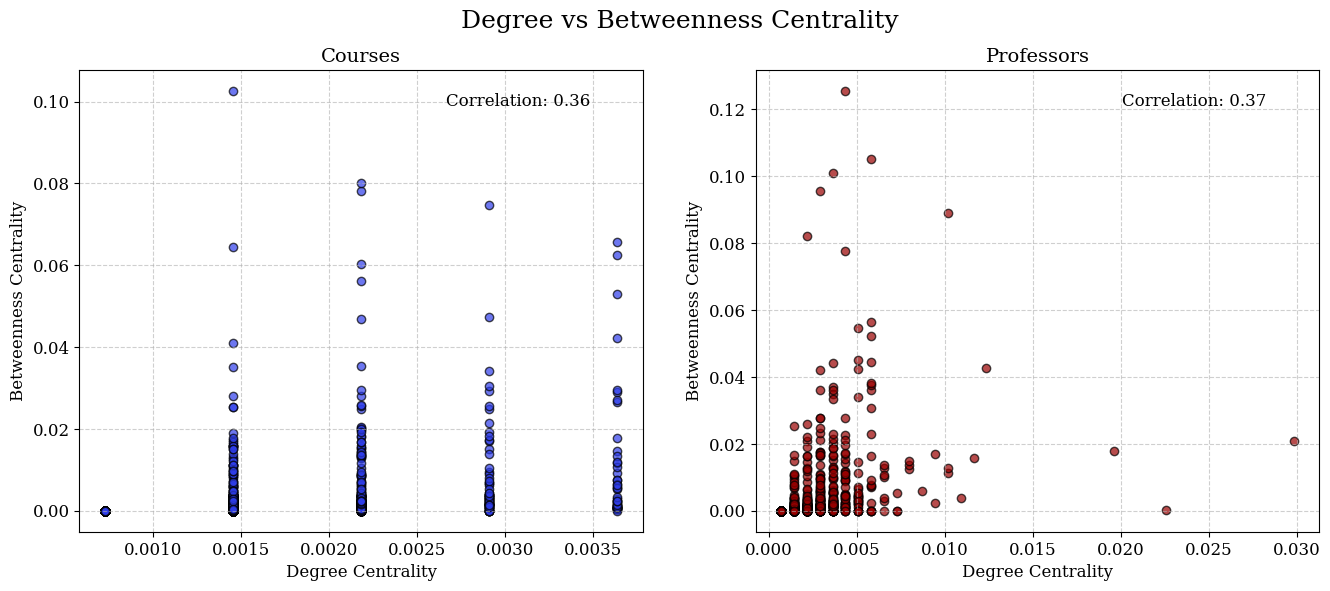

In [ ]:
course_degree_values = [degree_centrality[node] for node in course_nodes]
course_betweenness_values = [betweenness_centrality[node] for node in course_nodes]

professor_degree_values = [degree_centrality[node] for node in professor_nodes]
professor_betweenness_values = [
    betweenness_centrality[node] for node in professor_nodes
]

# Compute correlations
course_correlation = np.corrcoef(course_degree_values, course_betweenness_values)[0, 1]
professor_correlation = np.corrcoef(
    professor_degree_values, professor_betweenness_values
)[0, 1]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for courses
axes[0].scatter(
    course_degree_values,
    course_betweenness_values,
    alpha=0.7,
    color=BLUE,
    edgecolors="black",
)
axes[0].set_title("Courses", fontsize=14)
axes[0].set_xlabel("Degree Centrality", fontsize=12)
axes[0].set_ylabel("Betweenness Centrality", fontsize=12)
axes[0].text(
    0.65,
    0.95,
    f"Correlation: {course_correlation:.2f}",
    transform=axes[0].transAxes,
    fontsize=12,
    verticalalignment="top",
)
axes[0].grid(True, linestyle="--", alpha=0.6)

# Plot for professors
axes[1].scatter(
    professor_degree_values,
    professor_betweenness_values,
    alpha=0.7,
    color=RED,
    edgecolors="black",
)
axes[1].set_title("Professors", fontsize=14)
axes[1].set_xlabel("Degree Centrality", fontsize=12)
axes[1].set_ylabel("Betweenness Centrality", fontsize=12)
axes[1].text(
    0.65,
    0.95,
    f"Correlation: {professor_correlation:.2f}",
    transform=axes[1].transAxes,
    fontsize=12,
    verticalalignment="top",
)
axes[1].grid(True, linestyle="--", alpha=0.6)
plt.suptitle("Degree vs Betweenness Centrality", fontsize=18)
plt.show()

**Figure: Degree vs Betweenness Centrality** The first graph illustrates that courses tend to have a very low degree centrality with a slightly higher degree of betweenness centrality. This suggests that courses do not really serve as bridges between disconnected parts of the network. The second graph displays that professors tend to have a lower degree and betweenness centrality. This suggests that professors also do not serve as bridges to connect disconnected parts of the network. This could be due to the nature of it being a bipartite network in which the nodes are divided into two distinct sets and edges only exist between nodes from different sets. Similarly for the low correlation scores, the limited connections in the bipartite network can reduce the likelihood of a strong relationship between the two centralities.

## Exploratory Data analysis of Text

- Lecture 5, 6, 7, 8

* Week 5: Not much text in this week.

* Week 6: Maybe we can look into the lexical diversity of the course descriptions. However, I am not sure if this is relevant to our project.

* Week 7: This is the week of community detection. I guess we can try to detect communities of professors, and then use all their course descriptions to find similiarites and see if there is a better way to section the courses. There is also TF-IDF in this week, which we can use to find the most important words in the course descriptions.

* Week 8: This is the week of sentiment analysis. We can use this to see if the course descriptions are positive or negative, and see if this has any correlation with the grades or ratings of the courses.

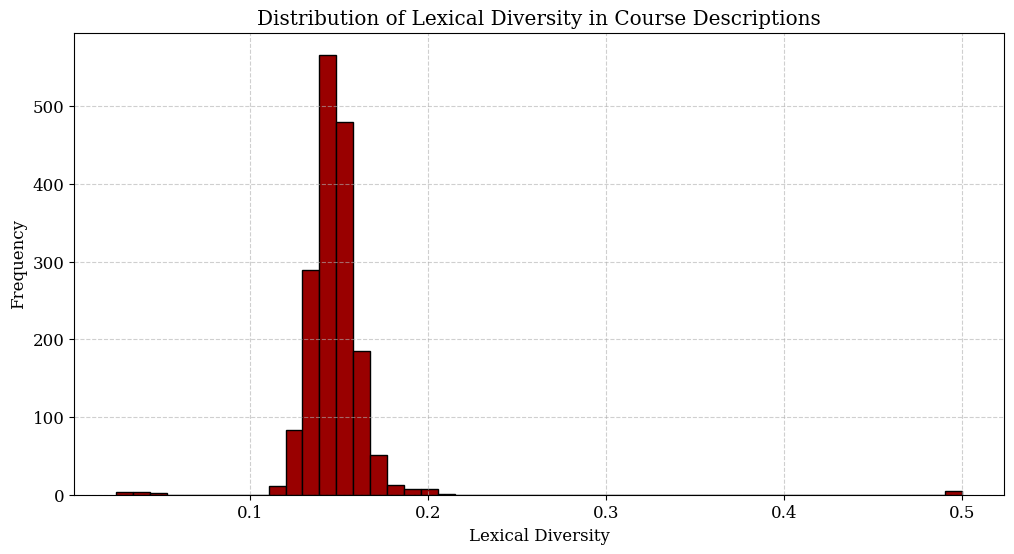

In [ ]:
# Week 6
# Calculate lexical diversity for each course description and plot the distribution
course_df["COURSE_DESCRIPTION"] = course_df["COURSE_DESCRIPTION"].fillna("")
lens = course_df["COURSE_DESCRIPTION"].apply(len)
words = course_df["COURSE_DESCRIPTION"].apply(lambda x: len(x.split()))

lexical_diversity = words / lens

plt.figure(figsize=(12, 6))
plt.hist(lexical_diversity, bins=50, color=RED, edgecolor="black")
plt.title("Distribution of Lexical Diversity in Course Descriptions")
plt.xlabel("Lexical Diversity")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Modularity of the partition: 0.9516341077430281


100%|██████████| 2000/2000 [00:48<00:00, 40.82it/s]


BarnesHut Approximation  took  17.48  seconds
Repulsion forces  took  28.52  seconds
Gravitational forces  took  0.33  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  1.52  seconds


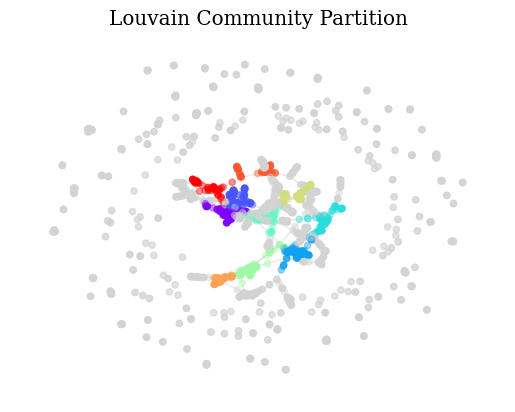

In [19]:
# Week 7
from fa2_modified import ForceAtlas2
from collections import defaultdict, Counter
import matplotlib.cm as cm
import community as community_louvain

# Partition the graph using the Louvain method
partition = community_louvain.best_partition(B)

# Calculate the modularity
modularity_value = community_louvain.modularity(partition, B)

print(f"Modularity of the partition: {modularity_value}")

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,
    verbose=True,
)
positions = forceatlas2.forceatlas2_networkx_layout(B, iterations=2000)

# **Partition by Louvain Method**
louvain_partition = community_louvain.best_partition(B)

community_sizes = Counter(louvain_partition.values())
largest_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)[
    :10
]
colors = cm.rainbow(np.linspace(0, 1, len(largest_communities)))

# set node colors
node_colors_louvain = []
for node in B.nodes():
    community_id = louvain_partition[node]
    if community_id in largest_communities:
        color_index = largest_communities.index(community_id)
        node_colors_louvain.append(colors[color_index])
    else:
        node_colors_louvain.append("lightgray")


plt.title("Louvain Community Partition")
nx.draw_networkx_nodes(
    B,
    pos=positions,
    node_color=node_colors_louvain,
    node_size=20,
    alpha=0.4,
)
nx.draw_networkx_edges(B, pos=positions, edge_color="lightgray", alpha=0.5)
plt.axis("off")

plt.show()

/var/folders/6l/_d0k81l969n6zvw6fgpq650w0000gn/T/ipykernel_52529/3695570126.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


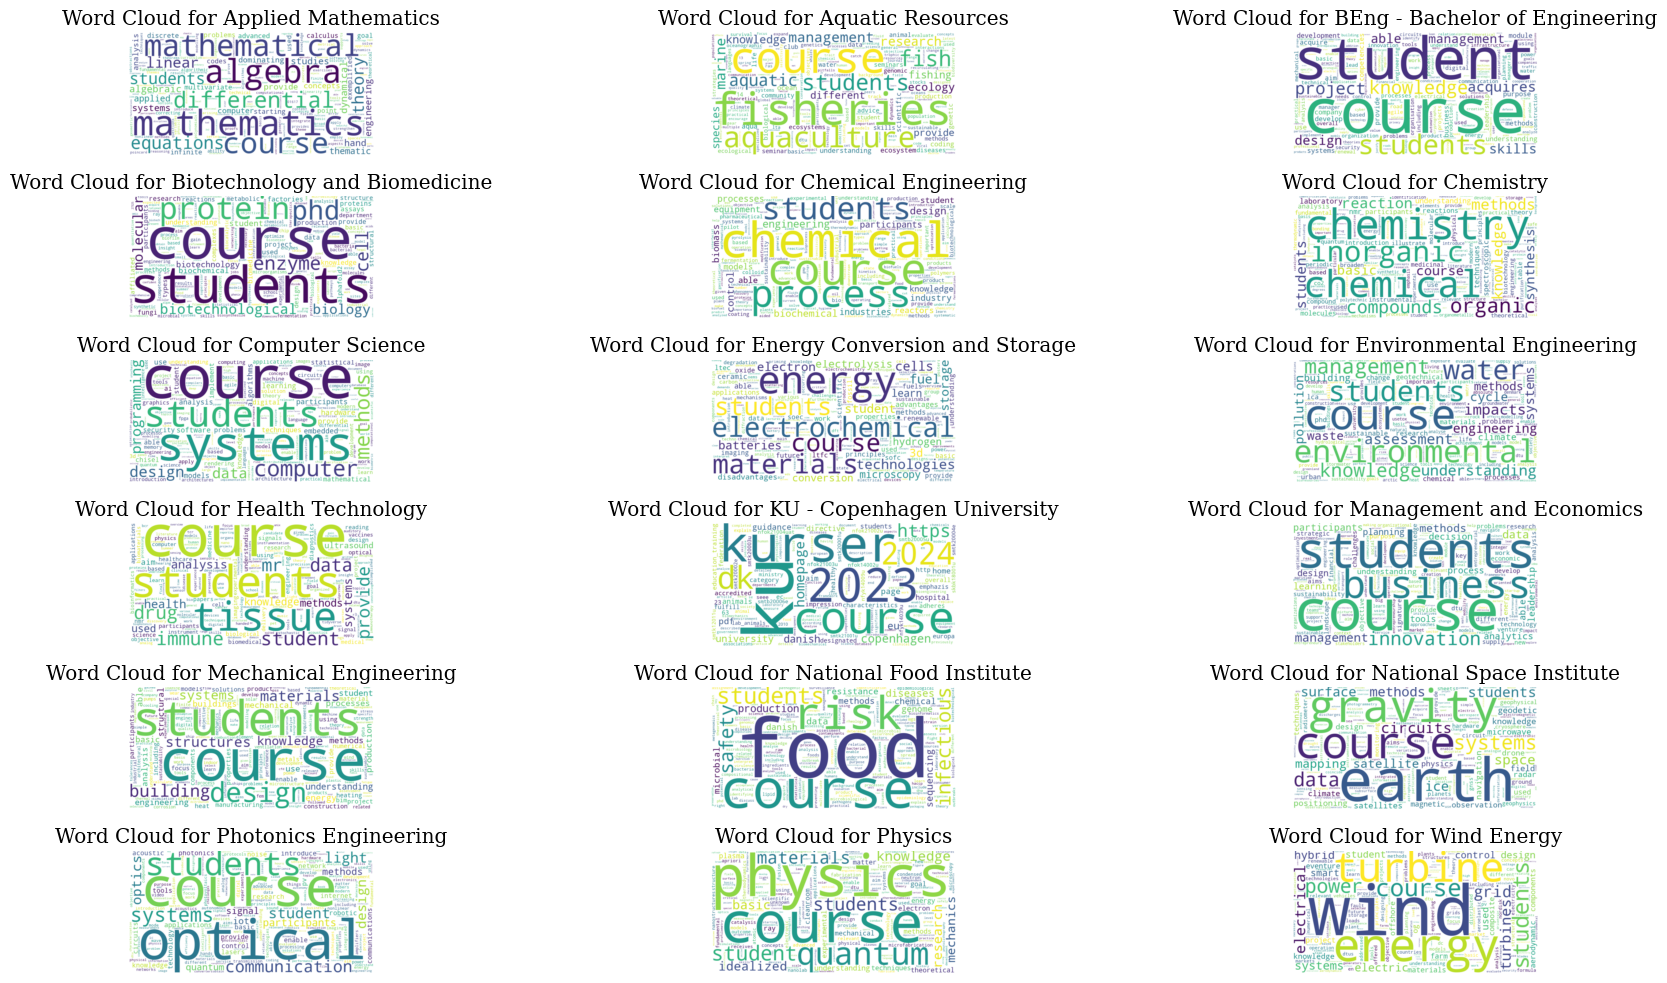

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from bs4 import BeautifulSoup


# Function to remove HTML tags
def clean_html(text):
    return BeautifulSoup(text, "html.parser").get_text()


# Group course nodes by institute
institute_courses = course_df.groupby("INSTITUTE")["COURSE"].apply(list).to_dict()

# Combine course descriptions and learning objectives, and remove HTML tags
course_df["TEXT"] = (course_df["COURSE_DESCRIPTION"].fillna("")).apply(clean_html)

# Create a dictionary to store the combined text for each institute
institute_texts = {
    inst: " ".join(course_df[course_df["COURSE"].isin(courses)]["TEXT"])
    for inst, courses in institute_courses.items()
}

# Perform TF-IDF
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(institute_texts.values())
feature_names = vectorizer.get_feature_names_out()

# Create word clouds for each institute in a nxm subplot
n = 6  # number of rows
m = 3  # number of columns
fig, axes = plt.subplots(n, m, figsize=(20, 10))

for ax, (idx, inst) in zip(axes.flatten(), enumerate(institute_texts.keys())):
    tfidf_scores = tfidf_matrix[idx].toarray().flatten()
    tfidf_dict = dict(zip(feature_names, tfidf_scores))

    wordcloud = WordCloud(
        width=800, height=400, background_color="white"
    ).generate_from_frequencies(tfidf_dict)

    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(f"Word Cloud for {inst}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Main Analysis

### The Simple Approach
In this first part of the analysis, we examine a straightforward method for professor-course alignment. We do this by comparing each professor's combined fingerprint and Scholia topics (keywords) with the aggregated course descriptions and learning objectives of the courses they teach. We calculate the recall of the alignment by measuring the proportion of the professor's keywords found in the aggregated course texts. This approach allows the course descriptions to include extra information without penalizing the alignment but focuses on whether the essential topics (professor's keywords) are covered in the courses associated with each professor.

In [21]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)


# Function to preprocess text
def preprocess_text(text):
    # Lowercase and remove punctuation
    translator = str.maketrans("", "", string.punctuation)
    text = text.lower().translate(translator)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [22]:
professor_recall_results = []

for prof_name, prof_data in B.nodes(data=True):
    if prof_data.get("type") == "Professor":
        fingerprints = prof_data.get("Fingerprint", [])
        scholia_topics = prof_data.get("scholia_topics", [])

        fingerprints = [f["Concept"] for f in fingerprints]
        scholia_topics = [t["topic"] for t in scholia_topics]

        prof_keywords = fingerprints + scholia_topics
        if not prof_keywords:
            continue

        prof_keywords_processed = []
        for kw in prof_keywords:
            translator = str.maketrans("", "", string.punctuation)
            kw_clean = kw.lower().translate(translator)
            tokens = word_tokenize(kw_clean)
            prof_keywords_processed.extend(tokens)
        prof_keywords_processed = list(set(prof_keywords_processed))

        if not prof_keywords_processed:
            continue

        connected_courses = [
            neighbor
            for neighbor in B.neighbors(prof_name)
            if B.nodes[neighbor].get("type") == "Course"
        ]

        all_course_text = ""

        for course_id in connected_courses:
            course_data = B.nodes[course_id]
            course_desc = course_data.get("COURSE_DESCRIPTION", "")
            learning_objectives = course_data.get("LEARNING_OBJECTIVES", "")
            course_text = course_desc + " " + learning_objectives

            all_course_text += " " + course_text

        course_tokens = preprocess_text(all_course_text)

        tp = sum(1 for word in prof_keywords_processed if word in course_tokens)
        fn = len(prof_keywords_processed) - tp

        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        professor_recall_results.append(
            {
                "professor_name": prof_name,
                "tp": tp,
                "fn": fn,
                "recall": recall,
                "total_courses": len(connected_courses),
            }
        )

prof_results_df = pd.DataFrame(professor_recall_results)

print("Recall Scores at Professor Level:")
display(prof_results_df.sort_values(by="recall", ascending=False))

Recall Scores at Professor Level:


professor_name  tp   fn    recall  total_courses
65                  Ulrik Dam Nielsen  13    1  0.928571              7
865  Daniela Cristina Antelmi Pigosso  10    3  0.769231              3
941               Lars Jonas Brunskog  10    3  0.769231              5
593               Kevin Michael Smith   9    3  0.750000              6
426                    Cao Linh Hoang  11    4  0.733333              4
..                                ...  ..  ...       ...            ...
881            Marianne Uhre Jakobsen   0  268  0.000000              1
24                      Wenjing Zhang   0   17  0.000000              1
235          Liisa Johanna Välikangas   0   15  0.000000              3
944               Björgvin Hjartarson   0   13  0.000000              1
483                      Daniel Fozer   0   17  0.000000              1

[996 rows x 5 columns]

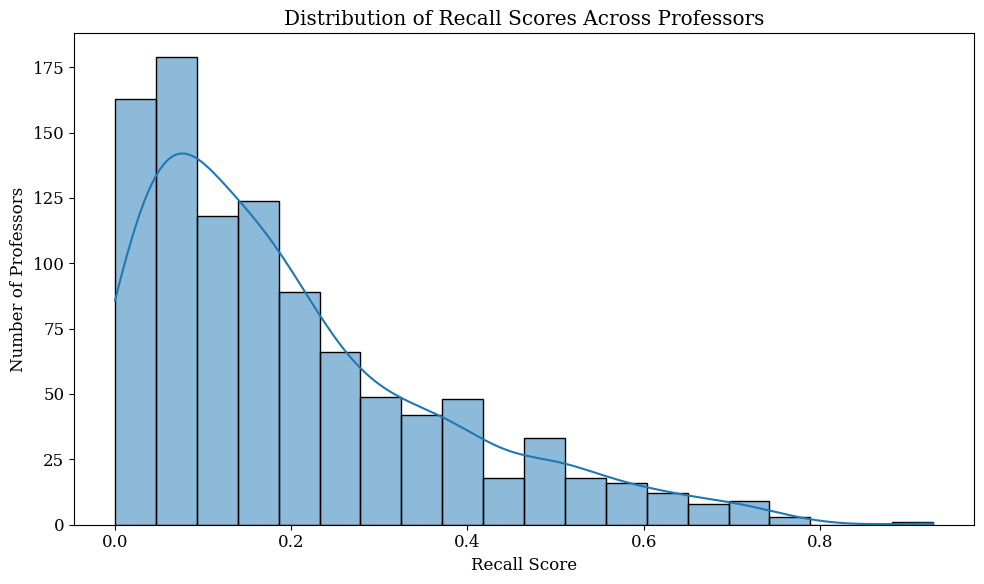

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(prof_results_df["recall"], kde=True, bins=20)  # , color='skyblue')
plt.xlabel("Recall Score")
plt.ylabel("Number of Professors")
plt.title("Distribution of Recall Scores Across Professors")
plt.tight_layout()
plt.show()

In [ ]:
from tqdm import tqdm


def create_prof_course_matrix(B):
    # Extract all professors' concepts first
    prof_concepts = {}
    for prof_name, prof_data in tqdm(B.nodes(data=True)):
        if prof_data.get("type") != "Professor":
            continue

        # Get concepts from both sources
        concepts = []
        fingerprints = prof_data.get("Fingerprint", [])
        scholia_topics = prof_data.get("scholia_topics", [])

        # Add concepts from fingerprints and scholia
        concepts.extend([f["Concept"].lower() for f in fingerprints])
        concepts.extend([t["topic"].lower() for t in scholia_topics])

        if concepts:
            prof_concepts[prof_name] = set(concepts)  # Using set for faster lookup

    # Initialize result dictionary
    recall_matrix = {}

    # Get all courses once
    courses = [
        node for node, data in B.nodes(data=True) if data.get("type") == "Course"
    ]

    # Calculate recall for each professor-course pair
    for prof_name, prof_concepts_set in tqdm(prof_concepts.items()):
        recall_matrix[prof_name] = {}

        for course_id in courses:
            course_data = B.nodes[course_id]
            course_text = " ".join(
                [
                    course_data.get("COURSE_DESCRIPTION", ""),
                    course_data.get("LEARNING_OBJECTIVES", ""),
                    course_data.get("COURSE_CONTENT", ""),
                ]
            ).lower()

            # course_text = preprocess_text(course_text)

            # Count matches
            matches = sum(1 for concept in prof_concepts_set if concept in course_text)
            total_concepts = len(prof_concepts_set)

            recall = matches / total_concepts if total_concepts > 0 else 0
            recall_matrix[prof_name][course_id] = recall

    # Convert to DataFrame
    df = pd.DataFrame(recall_matrix).T
    df = df.fillna(0)

    return df


recall_matrix_df = create_prof_course_matrix(B)
print("Professor-Course Matrix:")
display(recall_matrix_df)

recall_matrix_df.to_csv("data/similarity_recall_matrix_simple_approach.csv", index=True)

100%|██████████| 996/996 [01:29<00:00, 11.09it/s]


Professor-Course Matrix:


01001     01002  01003     01004  01005  01006  01015  \
Kim Knudsen               0.0  0.040000    0.0  0.040000    0.0    0.0    0.0   
Jesper Larsen             0.0  0.000000    0.0  0.000000    0.0    0.0    0.0   
Metodi Plamenov Yankov    0.0  0.000000    0.0  0.000000    0.0    0.0    0.0   
Rujie Zhu                 0.0  0.000000    0.0  0.000000    0.0    0.0    0.0   
Peter Steen Mikkelsen     0.0  0.010417    0.0  0.010417    0.0    0.0    0.0   
...                       ...       ...    ...       ...    ...    ...    ...   
Søren Zinck Kiil          0.0  0.000000    0.0  0.000000    0.0    0.0    0.0   
Arnold Knott              0.0  0.000000    0.0  0.000000    0.0    0.0    0.0   
Hans Malmborg Lilholt     0.0  0.000000    0.0  0.000000    0.0    0.0    0.0   
Maryamsadat Tahavori      0.0  0.000000    0.0  0.000000    0.0    0.0    0.0   
Hamid Sarlak              0.0  0.000000    0.0  0.000000    0.0    0.0    0.0   

                        01017  01018  01019  ...  62T38  62T39  62T90  \
Kim Knudsen               0.0    0.0    0.0  ...    0.0    0.0    0.0   
Jesper Larsen             0.0    0.0    0.0  ...    0.0    0.0    0.0   
Metodi Plamenov Yankov    0.0    0.0    0.0  ...    0.0    0.0    0.0   
Rujie Zhu                 0.0    0.0    0.0  ...    0.0    0.0    0.0   
Peter Steen Mikkelsen     0.0    0.0    0.0  ...    0.0    0.0    0.0   
...                       ...    ...    ...  ...    ...    ...    ...   
Søren Zinck Kiil          0.0    0.0    0.0  ...    0.0    0.0    0.0   
Arnold Knott              0.0    0.0    0.0  ...    0.0    0.0    0.0   
Hans Malmborg Lilholt     0.0    0.0    0.0  ...    0.0    0.0    0.0   
Maryamsadat Tahavori      0.0    0.0    0.0  ...    0.0    0.0    0.0   
Hamid Sarlak              0.0    0.0    0.0  ...    0.0    0.0    0.0   

                           63850  63851  63852  63860  63861     63880  \
Kim Knudsen             0.000000    0.0    0.0    0.0    0.0  0.000000   
Jesper Larsen           0.000000    0.0    0.0    0.0    0.0  0.125000   
Metodi Plamenov Yankov  0.000000    0.0    0.0    0.0    0.0  0.000000   
Rujie Zhu               0.000000    0.0    0.0    0.0    0.0  0.000000   
Peter Steen Mikkelsen   0.000000    0.0    0.0    0.0    0.0  0.010417   
...                          ...    ...    ...    ...    ...       ...   
Søren Zinck Kiil        0.020408    0.0    0.0    0.0    0.0  0.000000   
Arnold Knott            0.000000    0.0    0.0    0.0    0.0  0.000000   
Hans Malmborg Lilholt   0.000000    0.0    0.0    0.0    0.0  0.000000   
Maryamsadat Tahavori    0.000000    0.0    0.0    0.0    0.0  0.000000   
Hamid Sarlak            0.000000    0.0    0.0    0.0    0.0  0.000000   

                           63881  
Kim Knudsen             0.000000  
Jesper Larsen           0.125000  
Metodi Plamenov Yankov  0.000000  
Rujie Zhu               0.000000  
Peter Steen Mikkelsen   0.010417  
...                          ...  
Søren Zinck Kiil        0.000000  
Arnold Knott            0.000000  
Hans Malmborg Lilholt   0.000000  
Maryamsadat Tahavori    0.000000  
Hamid Sarlak            0.000000  

[996 rows x 1688 columns]

### NLP Approach (Similarity between courses and research topics of professors)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    CountVectorizer,
    TfidfTransformer,
)
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import json

# Load Data
with open("data/all_professors.json", "r") as f:
    professors_data = json.load(f)

file_path = "data/course_df.csv"
course_df = pd.read_csv(file_path)

# Download NLTK data (if not already downloaded)
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("omw-1.4")


def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove punctuation and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into a string
    preprocessed_text = " ".join(tokens)
    return preprocessed_text


# Function to preprocess and extract concepts from text
def extract_keywords(text):
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    # Lowercase and lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [
        lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalpha()
    ]

    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

[nltk_data] Downloading package punkt to /Users/erikriise/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/erikriise/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/erikriise/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/erikriise/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Simple Bag of Words

In [ ]:
# Prepare professors' concept vectors
professors_concepts = {}
all_concepts = set()

for prof, data in professors_data.items():
    concepts = []
    # Extract concepts from Fingerprint
    for item in data.get("Fingerprint", []):
        concepts.append(item["Concept"])
    # Extract topics from scholia_topics
    for item in data.get("scholia_topics", []):
        concepts.append(item["topic"])
    # Preprocess concepts
    concepts = [concept.lower() for concept in concepts]
    professors_concepts[prof] = concepts
    all_concepts.update(concepts)

# Prepare courses' concept vectors
courses_concepts = {}
for idx, row in course_df.iterrows():
    course_text = " ".join(
        [row["COURSE_DESCRIPTION"], row["LEARNING_OBJECTIVES"], row["COURSE_CONTENT"]]
    )
    concepts = extract_keywords(course_text)
    courses_concepts[row["COURSE"]] = concepts
    all_concepts.update(concepts)

# Create a list of all unique concepts
all_concepts = list(all_concepts)

# Create concept vectors for professors
professors_vectors = []
for prof in professors_data.keys():
    vector = [0] * len(all_concepts)
    prof_concepts = professors_concepts[prof]
    for concept in prof_concepts:
        if concept in all_concepts:
            idx = all_concepts.index(concept)
            vector[idx] += 1
    professors_vectors.append(vector)

# Create concept vectors for courses
courses_vectors = []
for course in course_df["COURSE"]:
    vector = [0] * len(all_concepts)
    course_concepts = courses_concepts[course]
    for concept in course_concepts:
        if concept in all_concepts:
            idx = all_concepts.index(concept)
            vector[idx] += 1
    courses_vectors.append(vector)

# Convert vectors to numpy arrays
professors_vectors = np.array(professors_vectors)
courses_vectors = np.array(courses_vectors)

# Compute similarity matrix
similarity_matrix = cosine_similarity(professors_vectors, courses_vectors)

# Create DataFrame for similarity scores
bog_similarity_df = pd.DataFrame(
    similarity_matrix, index=professors_data.keys(), columns=course_df["COURSE"]
)

bog_similarity_df.to_csv("data/similarity_bag_of_words.csv", index=True)

### Unweighted TF-IDF

In [ ]:
# Prepare professors' text data
professors_text = {}
for prof, data in professors_data.items():
    # Combine all textual information
    text_parts = []
    # Add Profile Description
    profile_desc = data.get("Profile_desc", "")
    text_parts.append(profile_desc)
    # Add Fingerprint Concepts
    fingerprint_concepts = [item["Concept"] for item in data.get("Fingerprint", [])]
    text_parts.extend(fingerprint_concepts)
    # Add Scholia Topics
    scholia_topics = [item["topic"] for item in data.get("scholia_topics", [])]
    text_parts.extend(scholia_topics)
    # Combine into one text
    full_text = " ".join(text_parts)
    # Preprocess the text
    preprocessed_text = preprocess_text(full_text)
    professors_text[prof] = preprocessed_text

# Prepare courses' text data
courses_text = {}
for idx, row in course_df.iterrows():
    # Combine course descriptions
    text_parts = [
        row.get("COURSE_DESCRIPTION", ""),
        row.get("LEARNING_OBJECTIVES", ""),
        row.get("COURSE_CONTENT", ""),
    ]
    full_text = " ".join(text_parts)
    # Preprocess the text
    preprocessed_text = preprocess_text(full_text)
    courses_text[row["COURSE"]] = preprocessed_text

# Combine all texts
all_texts = list(professors_text.values()) + list(courses_text.values())

# Initialize and fit the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(all_texts)

# Transform texts into TF-IDF vectors
professors_vectors = vectorizer.transform(professors_text.values())
courses_vectors = vectorizer.transform(courses_text.values())

# Compute similarity matrix
similarity_matrix = cosine_similarity(professors_vectors, courses_vectors)

# Create DataFrame for similarity scores
unweighted_tfidf_similarity_df = pd.DataFrame(
    similarity_matrix, index=professors_text.keys(), columns=courses_text.keys()
)

unweighted_tfidf_similarity_df.to_csv(
    "data/similarity_tfidf_unweighted.csv", index=True
)

### Weighted TF-IDF by fingerprints and scholia topics

In [ ]:
# Prepare professors' term frequencies with weights
professors_term_weights = {}
all_terms = set()

for prof, data in professors_data.items():
    term_weights = {}
    # Extract 'Fingerprint' concepts and their weights
    for item in data.get("Fingerprint", []):
        term = preprocess_text(item["Concept"])
        value_str = item.get("Value", "0%").strip("%")
        weight = float(value_str)  # Convert percentage string to float
        term_weights[term] = term_weights.get(term, 0) + weight
        all_terms.add(term)
    # Extract 'scholia_topics' and their scores
    for item in data.get("scholia_topics", []):
        term = preprocess_text(item["topic"])
        weight = float(item.get("score", 0))
        term_weights[term] = term_weights.get(term, 0) + weight
        all_terms.add(term)
    professors_term_weights[prof] = term_weights

# Prepare courses' text data
course_texts = []
course_names = []

for idx, row in course_df.iterrows():
    # Combine course descriptions
    text_parts = [
        row.get("COURSE_DESCRIPTION", ""),
        row.get("LEARNING_OBJECTIVES", ""),
        row.get("COURSE_CONTENT", ""),
    ]
    full_text = " ".join(text_parts)
    # Preprocess the text
    preprocessed_text = preprocess_text(full_text)
    course_texts.append(preprocessed_text)
    course_names.append(row["COURSE"])

# Build the vocabulary
vectorizer_for_vocab = CountVectorizer()
vectorizer_for_vocab.fit(course_texts)
course_terms = set(vectorizer_for_vocab.get_feature_names_out())

vocabulary = list(all_terms.union(course_terms))

# Vectorize courses
vectorizer = CountVectorizer(vocabulary=vocabulary)
course_term_counts = vectorizer.transform(course_texts)

tfidf_transformer = TfidfTransformer()
course_tfidf = tfidf_transformer.fit_transform(course_term_counts)

# Vectorize professors with weights
professors_term_counts = []
professor_names = []

for prof in professors_data.keys():
    term_weights = professors_term_weights[prof]
    term_count_vector = [0.0] * len(vocabulary)
    for term, weight in term_weights.items():
        if term in vocabulary:
            idx = vocabulary.index(term)
            term_count_vector[idx] = weight
    professors_term_counts.append(term_count_vector)
    professor_names.append(prof)

professors_term_counts = np.array(professors_term_counts)

professors_tfidf = tfidf_transformer.transform(professors_term_counts)

# Compute cosine similarity
similarity_matrix = cosine_similarity(professors_tfidf, course_tfidf)

# Create DataFrame for similarity scores
weighted_tfidf_similarity_df = pd.DataFrame(
    similarity_matrix, index=professor_names, columns=course_names
)

weighted_tfidf_similarity_df.to_csv("data/similarity_tfidf_weighted.csv", index=True)

### Weighted normalized TF-IDF by fingerprints and scholia topics

In [ ]:
# Prepare professors' term frequencies with weights
professors_term_weights = {}
all_terms = set()

for prof, data in professors_data.items():
    term_weights = {}
    # Extract 'Fingerprint' concepts and their weights
    for item in data.get("Fingerprint", []):
        term = preprocess_text(item["Concept"])
        value_str = item.get("Value", "0%").strip("%")
        weight = float(value_str)  # Convert percentage string to float
        term_weights[term] = term_weights.get(term, 0) + weight
        all_terms.add(term)
    # Extract 'scholia_topics' and their scores
    for item in data.get("scholia_topics", []):
        term = preprocess_text(item["topic"])
        weight = float(item.get("score", 0))
        term_weights[term] = term_weights.get(term, 0) + weight
        all_terms.add(term)
    professors_term_weights[prof] = term_weights

# Normalize professors' weights per professor individually
from sklearn.preprocessing import MinMaxScaler

for prof in professors_term_weights:
    term_weights = professors_term_weights[prof]
    weights = np.array(list(term_weights.values())).reshape(-1, 1)
    if not term_weights:
        continue
    # Proceed with normalization and the rest of the code
    # Check if all weights are the same
    if np.all(weights == weights[0]):
        # If all weights are the same, set them to a constant value (e.g., 1)
        normalized_weights = np.ones_like(weights).flatten()
    else:
        scaler = MinMaxScaler(feature_range=(1, 15))
        normalized_weights = scaler.fit_transform(weights).flatten()
    # Map normalized weights back to terms
    for idx, term in enumerate(term_weights):
        term_weights[term] = normalized_weights[idx]

# Prepare courses' text data
course_texts = []
course_names = []

for idx, row in course_df.iterrows():
    # Combine course descriptions
    text_parts = [
        row.get("COURSE_DESCRIPTION", ""),
        row.get("LEARNING_OBJECTIVES", ""),
        row.get("COURSE_CONTENT", ""),
    ]
    full_text = " ".join(text_parts)
    # Preprocess the text
    preprocessed_text = preprocess_text(full_text)
    course_texts.append(preprocessed_text)
    course_names.append(row["COURSE"])

# Build the vocabulary
vectorizer_for_vocab = CountVectorizer()
vectorizer_for_vocab.fit(course_texts)
course_terms = set(vectorizer_for_vocab.get_feature_names_out())

vocabulary = list(all_terms.union(course_terms))

# Vectorize courses
vectorizer = CountVectorizer(vocabulary=vocabulary)
course_term_counts = vectorizer.transform(course_texts)

# Vectorize professors with normalized weights
professors_term_counts = []
professor_names = []

for prof in professors_data.keys():
    term_weights = professors_term_weights[prof]
    term_count_vector = [0.0] * len(vocabulary)
    for term, weight in term_weights.items():
        if term in vocabulary:
            idx = vocabulary.index(term)
            term_count_vector[idx] = weight
    professors_term_counts.append(term_count_vector)
    professor_names.append(prof)

professors_term_counts = np.array(professors_term_counts)

# Combine term-frequency matrices
combined_term_counts = np.vstack([professors_term_counts, course_term_counts.toarray()])

# Apply TF-IDF transformation on combined data
tfidf_transformer = TfidfTransformer()
combined_tfidf = tfidf_transformer.fit_transform(combined_term_counts)

# Extract TF-IDF vectors
num_professors = len(professors_data)
professors_tfidf = combined_tfidf[:num_professors]
courses_tfidf = combined_tfidf[num_professors:]

# Compute cosine similarity
similarity_matrix = cosine_similarity(professors_tfidf, courses_tfidf)

# Create DataFrame for similarity scores
weighted_normalized_tfidf_similarity_df = pd.DataFrame(
    similarity_matrix, index=professor_names, columns=course_names
)

weighted_normalized_tfidf_similarity_df.to_csv(
    "data/similarity_tfidf_weighted_normalized.csv", index=True
)

### Transformer (model: stella 400m)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    CountVectorizer,
    TfidfTransformer,
)
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import json
import string
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist


# Download NLTK data (if not already downloaded)
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("punkt_tab")


def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove punctuation and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    tokens = [word for word in tokens if word != "br"]
    # Join tokens back into a string
    preprocessed_text = " ".join(tokens)
    return preprocessed_text


# Function to preprocess and extract concepts from text
def extract_keywords(text):
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    # Lowercase and lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [
        lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalpha()
    ]

    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens


def main():
    course_df = pd.read_csv("data/course_df.csv")

    with open("data/all_professors.json", "r") as file:
        professors_data = json.load(file)

    model = SentenceTransformer(
        "dunzhang/stella_en_400M_v5", trust_remote_code=True
    ).cuda()

    # Combine professor data into a single textual input
    professor_texts = {
        prof_name: " ".join(
            [
                prof_data.get("Profile_desc", ""),
                " ".join(prof_data.get("Keywords", [])),
                " ".join([fp["Concept"] for fp in prof_data.get("Fingerprint", [])]),
                " ".join(
                    [topic["topic"] for topic in prof_data.get("scholia_topics", [])]
                ),
            ]
        )
        for prof_name, prof_data in professors_data.items()
    }

    # Combine course data into a single textual input
    course_texts = {
        row["COURSE"]: " ".join(
            [
                row["COURSE_DESCRIPTION"],
                row.get("LEARNING_OBJECTIVES", ""),
                row.get("COURSE_CONTENT", ""),
            ]
        )
        for course_name, row in course_df.iterrows()
    }

    courses_text_processed = {}

    for course_name, text in course_texts.items():
        # Preprocess the text
        preprocessed_text = preprocess_text(text)
        courses_text_processed[course_name] = preprocessed_text

    professors_text_processed = {}
    for prof_name, text in professor_texts.items():
        # Preprocess the text
        preprocessed_text = preprocess_text(text)
        professors_text_processed[prof_name] = preprocessed_text

    # Generate embeddings
    professor_embeddings = model.encode(
        list(professors_text_processed.values()), convert_to_tensor=True
    )
    course_embeddings = model.encode(
        list(courses_text_processed.values()), convert_to_tensor=True
    )

    # Compute similarity
    similarity_matrix = cosine_similarity(
        professor_embeddings.cpu().numpy(), course_embeddings.cpu().numpy()
    )

    # Create a DataFrame for readability

    similarity_llm = pd.DataFrame(
        similarity_matrix,
        index=professors_text_processed.keys(),
        columns=courses_text_processed.keys(),
    )

    # save the similarity matrix to a csv file
    similarity_llm.to_csv("data/similarity_cosine_transformer.csv", index=True)
    # Compute Euclidean distance
    euclidean_distance_matrix = cdist(
        professor_embeddings.cpu().numpy(),
        course_embeddings.cpu().numpy(),
        metric="euclidean",
    )

    # Convert to similarity (smaller distances imply greater similarity)
    euclidean_similarity_matrix = 1 / (1 + euclidean_distance_matrix)

    # Create a DataFrame
    similarity_llm_euclidean = pd.DataFrame(
        euclidean_similarity_matrix,
        index=professors_text_processed.keys(),
        columns=courses_text_processed.keys(),
    )

    # Save the DataFrame
    similarity_llm_euclidean.to_csv(
        "data/similarity_euclidian_transformer.csv", index=True
    )

    # Compute Manhattan distance
    manhattan_distance_matrix = cdist(
        professor_embeddings.cpu().numpy(),
        course_embeddings.cpu().numpy(),
        metric="cityblock",  # L1 norm
    )

    # Convert to similarity (smaller distances imply greater similarity)
    manhattan_similarity_matrix = 1 / (1 + manhattan_distance_matrix)

    # Create a DataFrame
    similarity_llm_manhattan = pd.DataFrame(
        manhattan_similarity_matrix,
        index=professors_text_processed.keys(),
        columns=courses_text_processed.keys(),
    )

    # Save the DataFrame
    similarity_llm_manhattan.to_csv(
        "data/similarity_manhattan_transformer.csv", index=True
    )


if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to /Users/erikriise/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/erikriise/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/erikriise/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/erikriise/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/Users/erikriise/anaconda3/envs/adl/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


AssertionError: please install xformers

### Transformer weighted sum

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import torch
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import json
from scipy.spatial.distance import cdist

# Load the model
model = SentenceTransformer("dunzhang/stella_en_400M_v5", trust_remote_code=True).cuda()


# Helper function to normalize weights
def normalize_weights(weights):
    weights = np.array(weights, dtype=np.float32)
    return weights / weights.sum() if weights.sum() > 0 else np.ones_like(weights)


def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove punctuation and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    tokens = [word for word in tokens if word != "br"]
    # Join tokens back into a string
    preprocessed_text = " ".join(tokens)
    return preprocessed_text


# Function to normalize scholia scores
def normalize_scholia_scores(scholia_topics):
    # Extract raw scores
    scores = np.array([float(topic.get("score", 0)) for topic in scholia_topics])

    if len(scores) == 0:  # Handle case with no scholia topics
        return []

    # Determine normalization range
    max_score = scores.max()
    normalization_max = max(
        max_score, 100
    )  # Use max(max_score, 100) as the upper bound

    # Normalize to [0, normalization_max]
    normalized_scores = (scores / normalization_max) * 100
    return normalized_scores


def main():
    # Prepare professor embeddings with weighted averaging
    course_df = pd.read_csv("data/course_df.csv")

    with open("data/all_professors.json", "r") as file:
        professors_data = json.load(file)

    model = SentenceTransformer(
        "dunzhang/stella_en_400M_v5", trust_remote_code=True
    ).cuda()

    # Combine course data into a single textual input
    course_texts = {
        row["COURSE"]: " ".join(
            [
                row["COURSE_DESCRIPTION"],
                row.get("LEARNING_OBJECTIVES", ""),
                row.get("COURSE_CONTENT", ""),
            ]
        )
        for course_name, row in course_df.iterrows()
    }

    courses_text_processed = {}

    for course_name, text in course_texts.items():
        # Preprocess the text
        preprocessed_text = preprocess_text(text)
        courses_text_processed[course_name] = preprocessed_text

    professor_embeddings = []
    c = 0
    for prof_name, prof_data in professors_data.items():
        # Start with the Profile_desc embedding (or a zero vector if empty)
        profile_desc = prof_data.get("Profile_desc", "").strip()
        if profile_desc:
            profile_desc = preprocess_text(profile_desc)
            profile_embedding = model.encode(profile_desc, convert_to_tensor=True)
        else:
            profile_embedding = torch.zeros(
                (model.get_sentence_embedding_dimension(),), device="cuda"
            )

        # Generate embeddings for Fingerprint concepts with weights
        fingerprint_weights = []
        fingerprint_embeddings = []
        for fp in prof_data.get("Fingerprint", []):
            concept = fp["Concept"]
            concept = preprocess_text(concept)
            weight = float(fp["Value"].strip("%")) if fp["Value"] else 0
            fingerprint_weights.append(weight)
            fingerprint_embeddings.append(model.encode(concept, convert_to_tensor=True))

        # Normalize and generate embeddings for scholia topics
        scholia_weights = []
        scholia_embeddings = []
        normalized_scores = normalize_scholia_scores(
            prof_data.get("scholia_topics", [])
        )
        for idx, topic in enumerate(prof_data.get("scholia_topics", [])):
            concept = topic["topic"]
            weight = normalized_scores[idx]
            scholia_weights.append(weight)
            scholia_embeddings.append(model.encode(concept, convert_to_tensor=True))

        # Normalize weights
        all_weights = normalize_weights([1] + fingerprint_weights + scholia_weights)
        all_embeddings = (
            [profile_embedding] + fingerprint_embeddings + scholia_embeddings
        )

        # Compute weighted average embedding
        weighted_embedding = torch.sum(
            torch.stack([w * emb for w, emb in zip(all_weights, all_embeddings)]), dim=0
        )
        professor_embeddings.append(weighted_embedding)

        c += 1

        print(f"Professor embeddings: {c}/{len(professors_data)}")

    # Prepare course embeddings
    course_embeddings = model.encode(
        list(courses_text_processed.values()), convert_to_tensor=True
    )

    # Compute similarity matrix
    similarity_matrix = cosine_similarity(
        torch.stack(professor_embeddings).cpu().numpy(), course_embeddings.cpu().numpy()
    )

    # Create a DataFrame
    professor_names = list(professors_data.keys())
    course_names = list(courses_text_processed.keys())
    similarity_llm_approach_1 = pd.DataFrame(
        similarity_matrix, index=professor_names, columns=course_names
    )

    # Optional: Save the DataFrame for further analysis
    similarity_llm_approach_1.to_csv(
        "data/similarity_cosine_transformer_weighted_sum.csv", index=True
    )

    # Compute Euclidean distance
    euclidean_distance_matrix = cdist(
        torch.stack(professor_embeddings).cpu().numpy(),
        course_embeddings.cpu().numpy(),
        metric="euclidean",
    )

    # Convert to similarity (smaller distances imply greater similarity)
    euclidean_similarity_matrix = 1 / (1 + euclidean_distance_matrix)

    # Create a DataFrame
    similarity_llm_euclidean = pd.DataFrame(
        euclidean_similarity_matrix, index=professor_names, columns=course_names
    )

    # Save the DataFrame
    similarity_llm_euclidean.to_csv(
        "data/similarity_euclidian_transformer_weighted_sum.csv", index=True
    )

    # Compute Manhattan distance
    manhattan_distance_matrix = cdist(
        torch.stack(professor_embeddings).cpu().numpy(),
        course_embeddings.cpu().numpy(),
        metric="cityblock",  # L1 norm
    )

    # Convert to similarity (smaller distances imply greater similarity)
    manhattan_similarity_matrix = 1 / (1 + manhattan_distance_matrix)

    # Create a DataFrame
    similarity_llm_manhattan = pd.DataFrame(
        manhattan_similarity_matrix, index=professor_names, columns=course_names
    )

    # Save the DataFrame
    similarity_llm_manhattan.to_csv(
        "data/similarity_manhattan_transformer_weighted_sum.csv", index=True
    )


if __name__ == "__main__":
    main()

AssertionError: please install xformers

### Transformer weighted text

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import json
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import torch
from scipy.spatial.distance import cdist


# Function to normalize scholia scores
def normalize_scholia_scores(scholia_topics):
    # Extract raw scores
    scores = np.array([float(topic.get("score", 0)) for topic in scholia_topics])

    if len(scores) == 0:  # Handle case with no scholia topics
        return []

    # Determine normalization range
    max_score = scores.max()
    normalization_max = max(
        max_score, 100
    )  # Use max(max_score, 100) as the upper bound

    # Normalize to [0, normalization_max]
    normalized_scores = (scores / normalization_max) * 100
    return normalized_scores


def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove punctuation and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    tokens = [word for word in tokens if word != "br"]
    # Join tokens back into a string
    preprocessed_text = " ".join(tokens)
    return preprocessed_text


def main():
    # Prepare professor embeddings with weighted text

    course_df = pd.read_csv("data/course_df.csv")

    with open("data/all_professors.json", "r") as file:
        professors_data = json.load(file)

    # Load the model
    model = SentenceTransformer(
        "dunzhang/stella_en_400M_v5", trust_remote_code=True
    ).cuda()

    course_texts = {
        row["COURSE"]: " ".join(
            [
                row["COURSE_DESCRIPTION"],
                row.get("LEARNING_OBJECTIVES", ""),
                row.get("COURSE_CONTENT", ""),
            ]
        )
        for course_name, row in course_df.iterrows()
    }

    courses_text_processed = {}

    for course_name, text in course_texts.items():
        # Preprocess the text
        preprocessed_text = preprocess_text(text)
        courses_text_processed[course_name] = preprocessed_text

    professor_embeddings = []
    for prof_name, prof_data in professors_data.items():
        # Start with Profile_desc
        profile_desc = prof_data.get("Profile_desc", "").strip()
        weighted_text = profile_desc if profile_desc else ""

        # Add Fingerprint concepts, weighted by their percentages
        for fp in prof_data.get("Fingerprint", []):
            concept = fp["Concept"]
            concept = preprocess_text(concept)
            weight = int(float(fp["Value"].strip("%")) if fp["Value"] else 0)
            weighted_text += " " + (" ".join([concept] * weight))

        # Add scholia topics, weighted by their normalized scores
        normalized_scores = normalize_scholia_scores(
            prof_data.get("scholia_topics", [])
        )
        for idx, topic in enumerate(prof_data.get("scholia_topics", [])):
            concept = topic["topic"]
            concept = preprocess_text(concept)
            weight = int(normalized_scores[idx])
            weighted_text += " " + (" ".join([concept] * weight))

        # Encode the weighted text
        embedding = model.encode(weighted_text, convert_to_tensor=True)
        professor_embeddings.append(embedding)

    # Prepare course embeddings
    course_embeddings = model.encode(
        list(courses_text_processed.values()), convert_to_tensor=True
    )

    # Compute similarity matrix
    similarity_matrix = cosine_similarity(
        torch.stack(professor_embeddings).cpu().numpy(), course_embeddings.cpu().numpy()
    )

    # Create a DataFrame
    professor_names = list(professors_data.keys())
    course_names = list(courses_text_processed.keys())
    similarity_llm_approach_2 = pd.DataFrame(
        similarity_matrix, index=professor_names, columns=course_names
    )

    similarity_llm_approach_2.to_csv(
        "data/similarity_transformer_weighted_text.csv", index=True
    )

    # Compute Euclidean distance
    euclidean_distance_matrix = cdist(
        torch.stack(professor_embeddings).cpu().numpy(),
        course_embeddings.cpu().numpy(),
        metric="euclidean",
    )

    # Convert to similarity (smaller distances imply greater similarity)
    euclidean_similarity_matrix = 1 / (1 + euclidean_distance_matrix)

    # Create a DataFrame
    similarity_llm_euclidean = pd.DataFrame(
        euclidean_similarity_matrix, index=professor_names, columns=course_names
    )

    # Save the DataFrame
    similarity_llm_euclidean.to_csv(
        "data/similarity_euclidian_transformer_weighted_text.csv", index=True
    )

    # Compute Manhattan distance
    manhattan_distance_matrix = cdist(
        torch.stack(professor_embeddings).cpu().numpy(),
        course_embeddings.cpu().numpy(),
        metric="cityblock",  # L1 norm
    )

    # Convert to similarity (smaller distances imply greater similarity)
    manhattan_similarity_matrix = 1 / (1 + manhattan_distance_matrix)

    # Create a DataFrame
    similarity_llm_manhattan = pd.DataFrame(
        manhattan_similarity_matrix, index=professor_names, columns=course_names
    )

    # Save the DataFrame
    similarity_llm_manhattan.to_csv(
        "data/similarity_manhattan_transformer_weighted_text.csv", index=True
    )


if __name__ == "__main__":
    main()

/Users/erikriise/anaconda3/envs/adl/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


AssertionError: please install xformers

###  Similarity from professors to professors based on Transformer weighted text

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
from scipy.spatial.distance import cdist
import json


# Function to normalize scholia scores
def normalize_scholia_scores(scholia_topics):
    # Extract raw scores
    scores = np.array([float(topic.get("score", 0)) for topic in scholia_topics])

    if len(scores) == 0:  # Handle case with no scholia topics
        return []

    # Determine normalization range
    max_score = scores.max()
    normalization_max = max(
        max_score, 100
    )  # Use max(max_score, 100) as the upper bound

    # Normalize to [0, normalization_max]
    normalized_scores = (scores / normalization_max) * 100
    return normalized_scores


def main():
    # Load the data
    course_df = pd.read_csv("data/course_df.csv")

    with open("data/all_professors.json", "r") as file:
        professors_data = json.load(file)

    # Load the transformer model
    model = SentenceTransformer(
        "dunzhang/stella_en_400M_v5", trust_remote_code=True
    ).cuda()

    # Prepare professor embeddings (reuse your code for weighted text)
    professor_embeddings = []
    professor_names = list(professors_data.keys())

    for prof_name, prof_data in professors_data.items():
        # Start with Profile_desc
        profile_desc = prof_data.get("Profile_desc", "").strip()
        weighted_text = profile_desc if profile_desc else ""

        # Add Fingerprint concepts, weighted by their percentages
        for fp in prof_data.get("Fingerprint", []):
            concept = fp["Concept"]
            weight = int(float(fp["Value"].strip("%")) if fp["Value"] else 0)
            weighted_text += " " + (" ".join([concept] * weight))

        # Add scholia topics, weighted by their normalized scores
        normalized_scores = normalize_scholia_scores(
            prof_data.get("scholia_topics", [])
        )
        for idx, topic in enumerate(prof_data.get("scholia_topics", [])):
            concept = topic["topic"]
            weight = int(normalized_scores[idx])
            weighted_text += " " + (" ".join([concept] * weight))

        # Encode the weighted text
        embedding = model.encode(weighted_text, convert_to_tensor=True)
        professor_embeddings.append(embedding)

    # Stack professor embeddings for pairwise similarity
    professor_embeddings_tensor = torch.stack(professor_embeddings)
    professor_embeddings_np = professor_embeddings_tensor.cpu().numpy()

    # Compute similarity matrix between professors
    professor_similarity_matrix = cosine_similarity(professor_embeddings_np)

    # Create a DataFrame for readability
    similarity_df = pd.DataFrame(
        professor_similarity_matrix, index=professor_names, columns=professor_names
    )

    # Save the professor similarity DataFrame
    similarity_df.to_csv("data/professor_cosine_weighted_text.csv", index=True)

    # Compute Euclidean distance
    euclidean_distance_matrix = cdist(
        professor_embeddings_np, professor_embeddings_np, metric="euclidean"
    )

    # Convert to similarity (smaller distances imply greater similarity)
    euclidean_similarity_matrix = 1 / (1 + euclidean_distance_matrix)

    # Create a DataFrame
    similarity_llm_euclidean = pd.DataFrame(
        euclidean_similarity_matrix, index=professor_names, columns=professor_names
    )

    # Save the DataFrame
    similarity_llm_euclidean.to_csv(
        "data/professor_euclidian_transformer_weighted_text.csv", index=True
    )

    # Compute Manhattan distance
    manhattan_distance_matrix = cdist(
        professor_embeddings_np, professor_embeddings_np, metric="cityblock"  # L1 norm
    )

    # Convert to similarity (smaller distances imply greater similarity)
    manhattan_similarity_matrix = 1 / (1 + manhattan_distance_matrix)

    # Create a DataFrame
    similarity_llm_manhattan = pd.DataFrame(
        manhattan_similarity_matrix, index=professor_names, columns=professor_names
    )

    # Save the DataFrame
    similarity_llm_manhattan.to_csv(
        "data/professor_manhattan_transformer_weighted_text.csv", index=True
    )


if __name__ == "__main__":
    main()

/Users/erikriise/anaconda3/envs/adl/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


AssertionError: please install xformers

### Compare methods

Since we don't know the ground truth of the similarity between the courses and the research topics of the professors, we can't say or know whether the methods we used are good or not at finding similarities. We will therefore use our domain knowledge to evaluate the methods. Since we ourselves study at DTU, we know some professors and their research and we also know some courses. We will therefore use this knowledge to evaluate the methods to see if they are good at finding similarities.

In [ ]:
# Read the similarity matrices
# Simple approach
similarity_recall_matrix = pd.read_csv(
    "data/similarity_recall_matrix_simple_approach.csv", index_col=0
)

# NLP Approaches
similarity_bag_of_words = pd.read_csv("data/similarity_bag_of_words.csv", index_col=0)
similarity_tfidf_unweighted = pd.read_csv(
    "data/similarity_tfidf_unweighted.csv", index_col=0
)
similarity_tfidf_weighted = pd.read_csv(
    "data/similarity_tfidf_weighted.csv", index_col=0
)
similarity_tfidf_weighted_normalized = pd.read_csv(
    "data/similarity_tfidf_weighted_normalized.csv", index_col=0
)

# Transformer approaches
# Cosine
similarity_cosine_transformer = pd.read_csv(
    "data/similarity_cosine_transformer.csv", index_col=0
)
similarity_cosine_transformer_weighted_sum = pd.read_csv(
    "data/similarity_cosine_transformer_weighted_sum.csv", index_col=0
)
similarity_cosine_transformer_weighted_text = pd.read_csv(
    "data/similarity_cosine_transformer_weighted_text.csv", index_col=0
)
# Euclidian
similarity_euclidian_transformer = pd.read_csv(
    "data/similarity_euclidian_transformer.csv", index_col=0
)
similarity_euclidian_transformer_weighted_sum = pd.read_csv(
    "data/similarity_euclidian_transformer_weighted_sum.csv", index_col=0
)
similarity_euclidian_transformer_weighted_text = pd.read_csv(
    "data/similarity_euclidian_transformer_weighted_text.csv", index_col=0
)
# Manhattan
similarity_manhattan_transformer = pd.read_csv(
    "data/similarity_manhattan_transformer.csv", index_col=0
)
similarity_manhattan_transformer_weighted_sum = pd.read_csv(
    "data/similarity_manhattan_transformer_weighted_sum.csv", index_col=0
)
similarity_manhattan_transformer_weighted_text = pd.read_csv(
    "data/similarity_manhattan_transformer_weighted_text.csv", index_col=0
)

FileNotFoundError: [Errno 2] No such file or directory: 'data/similarity_cosine_transformer_weighted_text.csv'

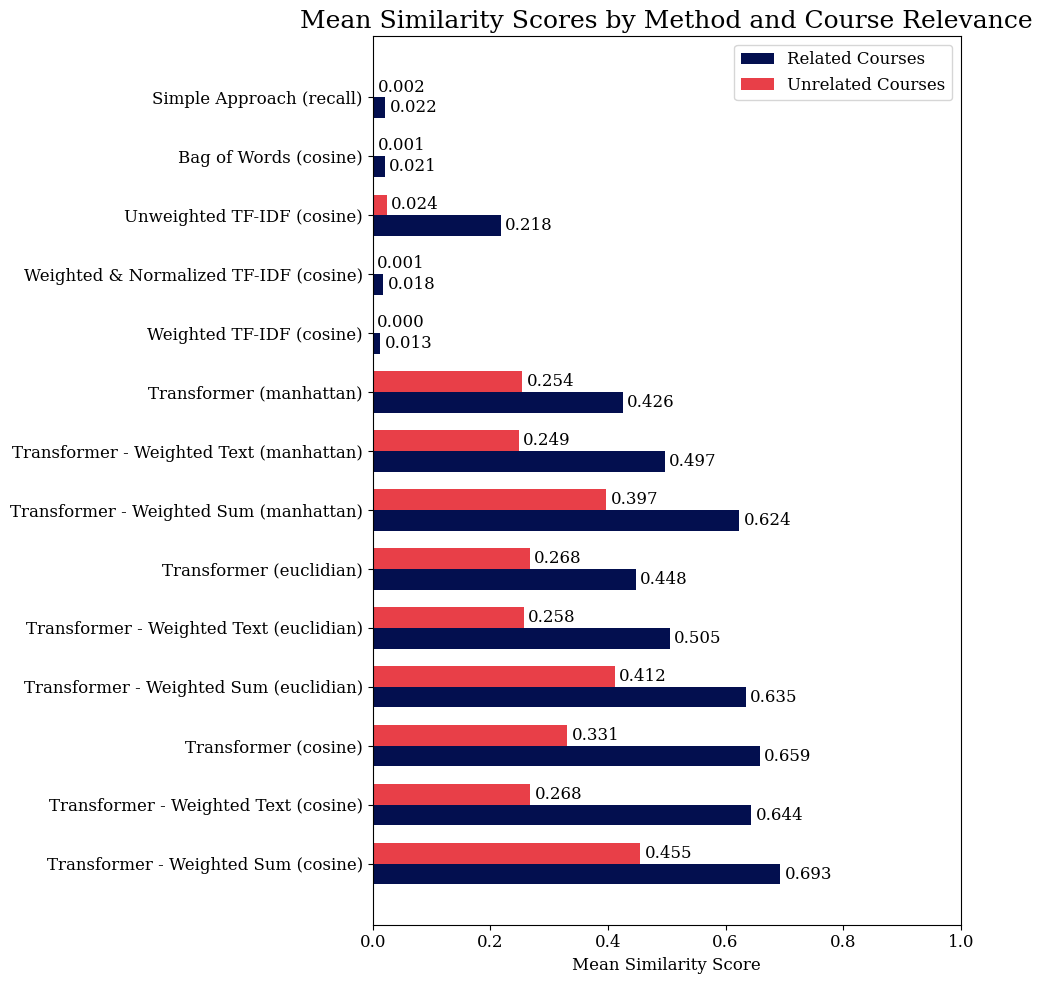

In [ ]:
# Your ground truth mapping
ground_truth = {
    "Sune Lehmann Jørgensen": {
        "related_courses": ["02805", "02806"],
        "unrelated_courses": ["30120", "30310", "12000", "12228"],
    },
    "Ole Winther": {
        "related_courses": ["02450", "02456"],
        "unrelated_courses": ["30120", "30310", "12000", "12228"],
    },
    "David Earl Roberson": {
        "related_courses": ["01227"],
        "unrelated_courses": ["30120", "30310", "12000", "12228"],
    },
    "Morten Mørup": {
        "related_courses": ["02901", "02450"],
        "unrelated_courses": ["30120", "30310", "12000", "12228"],
    },
    "Henrik Tange": {
        "related_courses": ["62426", "62T20"],
        "unrelated_courses": ["30120", "30310", "12000", "12228"],
    },
    "Aasa Feragen-Hauberg": {
        "related_courses": ["02516", "02501"],
        "unrelated_courses": ["62426", "62T20", "30120", "30310", "12000", "12228"],
    },
}

# List of methods and their similarity DataFrames
methods = {
    "Transformer - Weighted Sum (cosine)": similarity_cosine_transformer_weighted_sum,
    "Transformer - Weighted Text (cosine)": similarity_cosine_transformer_weighted_text,
    "Transformer (cosine)": similarity_cosine_transformer,
    "Transformer - Weighted Sum (euclidian)": similarity_euclidian_transformer_weighted_sum,
    "Transformer - Weighted Text (euclidian)": similarity_euclidian_transformer_weighted_text,
    "Transformer (euclidian)": similarity_euclidian_transformer,
    "Transformer - Weighted Sum (manhattan)": similarity_manhattan_transformer_weighted_sum,
    "Transformer - Weighted Text (manhattan)": similarity_manhattan_transformer_weighted_text,
    "Transformer (manhattan)": similarity_manhattan_transformer,
    "Weighted TF-IDF (cosine)": weighted_tfidf_similarity_df,
    "Weighted & Normalized TF-IDF (cosine)": weighted_normalized_tfidf_similarity_df,
    "Unweighted TF-IDF (cosine)": unweighted_tfidf_similarity_df,
    "Bag of Words (cosine)": bog_similarity_df,
    "Simple Approach (recall)": similarity_recall_matrix,
}

# Initialize dictionaries to store mean similarities
mean_similarities = {}

# For each method
for method_name, similarity_df in methods.items():
    # Normalize similarity scores within each method
    min_score = similarity_df.values.min()
    max_score = similarity_df.values.max()
    normalized_similarity_df = (similarity_df - min_score) / (max_score - min_score)

    # Initialize lists to store similarities
    related_similarities = []
    unrelated_similarities = []

    # For each professor
    for prof, courses_dict in ground_truth.items():
        related_courses = courses_dict["related_courses"]
        unrelated_courses = courses_dict["unrelated_courses"]

        # Check if professor is in the similarity DataFrame
        if prof in normalized_similarity_df.index:
            prof_similarities = normalized_similarity_df.loc[prof]

            # Get similarities for related courses
            existing_related_courses = [
                course
                for course in related_courses
                if course in prof_similarities.index
            ]
            related_scores = prof_similarities[existing_related_courses].values
            related_similarities.extend(related_scores)

            # Get similarities for unrelated courses
            existing_unrelated_courses = [
                course
                for course in unrelated_courses
                if course in prof_similarities.index
            ]
            unrelated_scores = prof_similarities[existing_unrelated_courses].values
            unrelated_similarities.extend(unrelated_scores)
        else:
            print(
                f"Professor '{prof}' not found in similarity DataFrame for method '{method_name}'."
            )

    # Compute mean similarities
    mean_related = np.mean(related_similarities) if related_similarities else 0
    mean_unrelated = np.mean(unrelated_similarities) if unrelated_similarities else 0

    # Store in dictionary
    mean_similarities[method_name] = {
        "Related Courses": mean_related,
        "Unrelated Courses": mean_unrelated,
    }
# Prepare data for plotting
methods_list = list(mean_similarities.keys())
related_means = [
    mean_similarities[method]["Related Courses"] for method in methods_list
]
unrelated_means = [
    mean_similarities[method]["Unrelated Courses"] for method in methods_list
]

# Plotting
y = np.arange(len(methods_list))  # label locations
height = 0.35  # height of the bars

fig, ax = plt.subplots(figsize=(10, 10))

# Create horizontal bars
rects1 = ax.barh(
    y - height / 2, related_means, height, label="Related Courses", color=NAVY
)
rects2 = ax.barh(
    y + height / 2, unrelated_means, height, label="Unrelated Courses", color=SALMON
)

# Add labels and title
ax.set_xlabel("Mean Similarity Score")
ax.set_title("Mean Similarity Scores by Method and Course Relevance")
ax.set_yticks(y)
ax.set_yticklabels(methods_list)
ax.legend()
ax.title.set_fontsize(18)
# set font size of labels on x-axis and y-axis
ax.tick_params(axis="both", which="major", labelsize=12)
# add x-axis limit
ax.set_xlim(0, 1)


# Function to add labels on top of bars
def autolabel_horizontal(rects):
    """Attach a text label beside each bar."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate(
            f"{width:.3f}",
            xy=(width, rect.get_y() + rect.get_height() / 2),
            xytext=(3, 0),  # Offset text slightly to the right
            textcoords="offset points",
            ha="left",
            va="center",
        )


autolabel_horizontal(rects1)
autolabel_horizontal(rects2)

plt.tight_layout()
plt.show()

Distribution of cosine similarities to double check we get a good enough spread of similarities

In [ ]:
# distribution of similarity scores of similarity_cosine_transformer_weighted_text
import seaborn as sns

# Prepare data for plotting
method_name = "Transformer - Weighted Text (cosine)"
similarity_df = methods[method_name]

# Flatten the DataFrame
similarity_values = similarity_df.values.flatten()

# Plotting
plt.figure(figsize=(12, 6))
sns.histplot(similarity_values, kde=True, color=RED)
plt.title(f"Distribution of Similarity Scores for Method: {method_name}", fontsize=20)
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
# plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

NameError: name 'methods' is not defined

### Permutation test

Statistical test where we test the null hypothesis that there are no differences between the similarities of courses that professors teach and courses that the professors don't teach. We see that there is a statistically significance difference. This means we can reject the null hypothesis in favor of the alternative hypothesis that professors indeed teach courses that are more relevant to them.

In [ ]:
# Load the similarity matrix (professors x courses)
similarity_matrix = pd.read_csv(
    "data/similarity_cosine_transformer_weighted_text.csv", index_col=0
)

# Load the course dataframe
course_df = pd.read_csv("data/course_df.csv")

# Columns in course_df that contain professor names
professor_columns = [
    "MAIN_RESPONSIBLE_NAME",
    "CO_RESPONSIBLE_1_NAME",
    "CO_RESPONSIBLE_2_NAME",
    "CO_RESPONSIBLE_3_NAME",
    "CO_RESPONSIBLE_4_NAME",
]

# Extract course-professor mappings efficiently
course_to_professors = {}
for _, row in course_df.iterrows():
    course = row["COURSE"]
    professors = [
        row[col]
        for col in professor_columns
        if isinstance(row[col], str) and row[col] != "NO_DATA"
    ]
    course_to_professors[course] = professors

# Prepare observed and baseline similarity scores
observed_similarities = []
baseline_similarities = []
# Prepare observed and baseline similarity scores
observed_similarities = []
baseline_similarities = []

# Loop through each course and its assigned professors
for course, professors in course_to_professors.items():
    # Filter out professors not in similarity_matrix index
    valid_professors = [prof for prof in professors if prof in similarity_matrix.index]

    # Check if course exists in similarity_matrix columns
    if course in similarity_matrix.columns and valid_professors:
        # Similarity scores for valid professors teaching this course
        observed_scores = similarity_matrix.loc[valid_professors, course].values
        observed_similarities.extend(observed_scores)

        # Similarity scores for other professors not teaching this course
        other_professors = [
            prof for prof in similarity_matrix.index if prof not in valid_professors
        ]
        baseline_scores = similarity_matrix.loc[other_professors, course].values
        baseline_similarities.extend(baseline_scores)

# Calculate the observed mean difference
observed_mean_difference = np.mean(observed_similarities) - np.mean(
    baseline_similarities
)

# Permutation test
num_permutations = 2000
null_differences = []
c = 0
for _ in range(num_permutations):

    # Shuffle all similarity scores
    shuffled_scores = np.random.permutation(
        observed_similarities + baseline_similarities
    )
    null_taught = shuffled_scores[: len(observed_similarities)]
    null_baseline = shuffled_scores[len(observed_similarities) :]
    null_mean_difference = np.mean(null_taught) - np.mean(null_baseline)
    null_differences.append(null_mean_difference)
    c += 1
    if c % 500 == 0:
        print(f"Permutation {c} out of {num_permutations} processed.")

# Calculate p-value
p_value = np.mean([diff >= observed_mean_difference for diff in null_differences])

print(f"Observed Mean Difference: {observed_mean_difference}")
print(f"P-Value: {p_value}")

FileNotFoundError: [Errno 2] No such file or directory: 'data/similarity_cosine_transformer_weighted_text.csv'

In [ ]:
import matplotlib as mpl

sns.set(style="whitegrid")
mpl.rcParams["font.family"] = "serif"
plt.figure(figsize=(12, 6))
sns.histplot(
    null_differences,
    bins=50,
    kde=True,
    color=NAVY,
    alpha=0.75,
    label="Distribution under Null Hypothesis",
)
plt.axvline(
    observed_mean_difference,
    color="red",
    linestyle="--",
    linewidth=5,
    label="Observed Difference",
)
plt.title("Permutation Test (p-value: 0)", fontsize=20)
plt.xlabel("Mean Difference", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=15)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

NameError: name 'null_differences' is not defined

<Figure size 1200x600 with 0 Axes>

### Departments and similarities

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add INSTITUTE column to course-to-professor mapping
course_to_professors = {}
course_to_institute = {}
for _, row in course_df.iterrows():
    course = row["COURSE"]
    professors = [
        row[col]
        for col in professor_columns
        if isinstance(row[col], str) and row[col] != "NO_DATA"
    ]
    course_to_professors[course] = professors
    course_to_institute[course] = row["INSTITUTE"]  # Add discipline information

# Prepare alignment scores by discipline
discipline_scores = []

for course, professors in course_to_professors.items():
    institute = course_to_institute[course]

    # Observed scores
    if course in similarity_matrix.columns:
        valid_professors = [
            prof for prof in professors if prof in similarity_matrix.index
        ]
        if valid_professors:
            observed_scores = similarity_matrix.loc[valid_professors, course].values
            for score in observed_scores:
                discipline_scores.append(
                    {"INSTITUTE": institute, "Score": score, "Type": "Assigned"}
                )

        # Baseline scores
        other_professors = [
            prof for prof in similarity_matrix.index if prof not in valid_professors
        ]
        if other_professors:
            baseline_scores = similarity_matrix.loc[other_professors, course].values
            for score in baseline_scores:
                discipline_scores.append(
                    {"INSTITUTE": institute, "Score": score, "Type": "Unassigned"}
                )

# Convert to DataFrame for visualization
discipline_scores_df = pd.DataFrame(discipline_scores)

discipline_scores_df = discipline_scores_df[
    ~discipline_scores_df["INSTITUTE"].isin(
        ["KU - Copenhagen University", "BEng - Bachelor of Engineering"]
    )
]

# Plot mean alignment scores by discipline
plt.figure(figsize=(14, 7))
# Do sns barplot with errorbars colored by "Type" where colours are RED and NAVY
custom_palette = {"Assigned": RED, "Unassigned": BLUE}

plt.figure(figsize=(14, 7))
sns.barplot(
    data=discipline_scores_df,
    x="INSTITUTE",
    y="Score",
    hue="Type",
    errorbar="sd",
    palette=custom_palette,
)
plt.title("Mean Similarity Scores by Discipline", fontsize=20)
plt.xlabel("Discipline (INSTITUTE)", fontsize=14)
plt.ylabel("Mean Similarity Score", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Course type", fontsize=15, loc="upper left")
plt.tight_layout()
plt.show()

# Plot distribution of similarity scores by discipline
# Remove from dataframe INSTITUTION "KU - Copenhagen Univesity" and "BEng - Bachelor of Engineering"
plt.figure(figsize=(14, 7))
sns.boxplot(
    data=discipline_scores_df,
    x="INSTITUTE",
    y="Score",
    hue="Type",
    palette=custom_palette,
)
plt.title("Distribution of Similarity Scores by Discipline", fontsize=20)
plt.xlabel("Discipline (INSTITUTE)", fontsize=14)
plt.ylabel("Similarity Score", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Course type", fontsize=15, loc="upper left")
plt.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

# 

## Grade and satisfaction alignment

Section for answering the second research question: "Does the alignment between professors’ research and the courses they teach influence student satisfaction and performance (grades)?"

### Correlation scores average grade/rating of courses

We calculate the correlation score between professors' course alignment scores and the average grades/ratings of those courses to assess the strength of their relationship, which will reveal whether better alignment between a professor's research and their courses correlates with higher student performance or ratings.

In [ ]:
similarity_df = similarity_cosine_transformer_weighted_text

course_grades = {
    course: B.nodes[course].get("AVERAGE_GRADE", None) for course in B.nodes
}
course_ratings = {
    course: B.nodes[course].get("RATING_AVERAGE_SCORE", None) for course in B.nodes
}

# Create DF with the professor, course, alignment score
professor_course_alignment_df = similarity_df.stack().reset_index()
professor_course_alignment_df.columns = ["professor", "course", "alignment_score"]

# Map grades and ratings to the DF
professor_course_alignment_df["average_grade"] = professor_course_alignment_df[
    "course"
].map(course_grades)
professor_course_alignment_df["rating_average_score"] = professor_course_alignment_df[
    "course"
].map(course_ratings)

# Filter out rows with 'Pass/Fail' or 'No data'
professor_course_alignment_df = professor_course_alignment_df[
    ~professor_course_alignment_df[["average_grade", "rating_average_score"]]
    .isin(["Pass/Fail", "No data"])
    .any(axis=1)
]
professor_course_alignment_df[["average_grade", "rating_average_score"]] = (
    professor_course_alignment_df[["average_grade", "rating_average_score"]].apply(
        pd.to_numeric, errors="coerce"
    )
)

correlation_grade = professor_course_alignment_df["alignment_score"].corr(
    professor_course_alignment_df["average_grade"]
)
correlation_rating = professor_course_alignment_df["alignment_score"].corr(
    professor_course_alignment_df["rating_average_score"]
)
print(f"Correlation between alignment score and average grade: {correlation_grade}")
print(
    f"Correlation between alignment score and rating average score: {correlation_rating}"
)

min_score = professor_course_alignment_df["alignment_score"].min()
max_score = professor_course_alignment_df["alignment_score"].max()
num_bins = 3

bins = np.linspace(min_score, max_score, num_bins + 1)
labels = ["Low", "Medium", "High"]

professor_course_alignment_df["alignment_category"] = pd.cut(
    professor_course_alignment_df["alignment_score"],
    bins=bins,
    labels=labels,
    include_lowest=True,
)

# Group by alignment_category and calculate mean values for grades and ratings
alignment_summary = (
    professor_course_alignment_df.groupby("alignment_category", observed=False)
    .agg(
        average_grade=("average_grade", "mean"),
        rating_average_score=("rating_average_score", "mean"),
    )
    .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for average grades
sns.barplot(
    data=alignment_summary,
    x="alignment_category",
    y="average_grade",
    color=RED,
    edgecolor="black",
    ax=axes[0],
)
axes[0].set_title("Impact of Alignment on Student Performance (Grades)", fontsize=16)
axes[0].set_xlabel("Similarity Category", fontsize=14)
axes[0].set_ylabel("Average Grade (Danish Scale)", fontsize=14)
danish_grades = [0, 2, 4, 7, 10, 12]
axes[0].set_yticks(danish_grades)
axes[0].set_yticklabels(danish_grades)

for index, value in enumerate(alignment_summary["average_grade"]):
    axes[0].text(
        index, value + 0.5, f"{value:.2f}", ha="center", va="bottom", fontsize=10
    )

plt.text(
    0.55,
    0.95,
    f"Correlation: {correlation_grade:.2f}",
    transform=axes[0].transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="center",
    color="black",
)

axes[0].set_ylim(0, 12)
axes[0].grid(axis="y", alpha=0.3)

# Plot for average ratings
sns.barplot(
    data=alignment_summary,
    x="alignment_category",
    y="rating_average_score",
    color=BLUE,
    edgecolor="black",
    ax=axes[1],
)
axes[1].set_title("Impact of Alignment on Student Satisfaction (Ratings)", fontsize=16)
axes[1].set_xlabel("Similarity Category", fontsize=14)
axes[1].set_ylabel("Average Rating", fontsize=14)

for index, value in enumerate(alignment_summary["rating_average_score"]):
    axes[1].text(
        index, value + 0.05, f"{value:.2f}", ha="center", va="bottom", fontsize=10
    )

plt.text(
    0.55,
    0.95,
    f"Correlation: {correlation_rating:.2f}",
    transform=axes[1].transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="center",
    color="black",
)

axes[1].set_ylim(0, 5)
axes[1].grid(axis="y", alpha=0.3)

fig.suptitle("Relationship Between Similarity Scores, Grades, and Ratings", fontsize=20)
plt.show()

NameError: name 'similarity_cosine_transformer_weighted_text' is not defined

**Figure: Relationship Between Similarity Scores, Grades, and Ratings** The data is binned into three categories based on similarity scores: low, medium, and high. The scores are calculated per course, not per category. Categorizations are for simpler data representation. These low correlation values suggest that alignment may not be a factor influencing student outcomes and satisfaction, with other factors likely playing a larger role.

### Correlation scores average grade/rating of courses per study line

Now we explore the correlation scores per study line to assess whether the scores will increase.

In [ ]:
study_line_grades = defaultdict(list)
study_line_ratings = defaultdict(list)
study_line_alignment_scores = defaultdict(list)

# Iterate over the nodes to collect grades, ratings, and alignment scores for each course by study line
for course, attributes in B.nodes(data=True):
    study_lines = attributes.get("STUDY_LINES", None)
    grade = attributes.get("AVERAGE_GRADE", None)
    rating = attributes.get("RATING_AVERAGE_SCORE", None)

    if study_lines and course in similarity_df.columns:
        # Process grades
        if grade not in ["Pass/Fail", "No data"]:
            grade = pd.to_numeric(grade, errors="coerce")
            if isinstance(study_lines, list):
                for study_line in study_lines:
                    study_line_grades[study_line].append(grade)

        # Process ratings
        if rating not in ["Pass/Fail", "No data"]:
            rating = pd.to_numeric(rating, errors="coerce")
            if isinstance(study_lines, list):
                for study_line in study_lines:
                    study_line_ratings[study_line].append(rating)

        # Process alignment scores
        for professor, alignment_score in similarity_df[course].items():
            if isinstance(study_lines, list):
                for study_line in study_lines:
                    study_line_alignment_scores[study_line].append(alignment_score)

# Calculate average grades, ratings, and alignment scores per study line
average_grades_per_study_line = {
    study_line: sum(grades) / len(grades)
    for study_line, grades in study_line_grades.items()
}

average_ratings_per_study_line = {
    study_line: sum(ratings) / len(ratings)
    for study_line, ratings in study_line_ratings.items()
}

average_alignment_per_study_line = {
    study_line: sum(scores) / len(scores)
    for study_line, scores in study_line_alignment_scores.items()
}

# Combine the alignment, grade, and rating data
alignment_data = []
for study_line, alignment_score in average_alignment_per_study_line.items():
    average_grade = average_grades_per_study_line.get(study_line, None)
    average_rating = average_ratings_per_study_line.get(study_line, None)
    if average_grade is not None and average_rating is not None:
        alignment_data.append(
            (study_line, alignment_score, average_grade, average_rating)
        )

# Create DataFrame and calculate correlations
study_line_corr_df = pd.DataFrame(
    alignment_data,
    columns=["study_line", "alignment_score", "average_grade", "average_rating"],
)
correlation_grade_study_line = study_line_corr_df["alignment_score"].corr(
    study_line_corr_df["average_grade"]
)
correlation_rating_study_line = study_line_corr_df["alignment_score"].corr(
    study_line_corr_df["average_rating"]
)

print(
    f"Correlation between average alignment score and average grade per study line: {correlation_grade_study_line}"
)
print(
    f"Correlation between average alignment score and average rating per study line: {correlation_rating_study_line}"
)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Scatter plot for alignment score vs. average grade
sns.regplot(
    data=study_line_corr_df,
    x="alignment_score",
    y="average_grade",
    ax=axes[0],
    scatter_kws={"color": RED, "s": 80, "edgecolor": "black"},
    line_kws={"color": BLUE, "lw": 2},
)
axes[0].set_title("Similarity Score vs. Average Grade", fontsize=16)
axes[0].set_xlabel("Similarity Score", fontsize=14)
axes[0].set_ylabel("Average Grade (Danish Scale)", fontsize=14)
danish_grades = [0, 2, 4, 7, 10, 12]
axes[0].set_yticks(danish_grades)
axes[0].set_yticklabels(danish_grades)
axes[0].grid(True)

plt.text(
    0.35,
    0.95,
    f"Correlation: {correlation_grade_study_line:.2f}",
    transform=axes[0].transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="center",
    color="black",
)

scatter_points = axes[0].collections[0]
line_plot = axes[0].lines[0]  #
axes[0].legend(
    [scatter_points, line_plot], ["Average Grade Study Line", "Regression Line"]
)

# Scatter plot for alignment score vs. average rating
sns.regplot(
    data=study_line_corr_df,
    x="alignment_score",
    y="average_rating",
    ax=axes[1],
    scatter_kws={"color": RED, "s": 80, "edgecolor": "black"},
    line_kws={"color": BLUE, "lw": 2},
)
axes[1].set_title("Similarity Score vs. Average Rating", fontsize=16)
axes[1].set_xlabel("Similarity Score", fontsize=14)
axes[1].set_ylabel("Average Rating", fontsize=14)
axes[1].grid(True)

plt.text(
    0.75,
    0.95,
    f"Correlation: {correlation_rating_study_line:.2f}",
    transform=axes[1].transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="center",
    color="black",
)


scatter_points = axes[1].collections[0]
line_plot = axes[1].lines[0]
axes[1].legend(
    [scatter_points, line_plot], ["Average Rating Study Line", "Regression Line"]
)


fig.suptitle(
    "Relationship Between Similarity Scores, Grades, and Ratings per Study Line",
    fontsize=20,
)
plt.show()

NameError: name 'similarity_df' is not defined

**Figure: Relationship Between Similarity Scores, Grades, and Ratings per Study Line** The red dots correspond to individual study lines (e.g. MSc. Computer Science, BSc. General Engineering). The blue regression line illustrates the relationship between the average grade/rating and similarity scores. The correlation scores show a weak positive relationship with grades (0.08) and a low positive relationship with course ratings (0.33). These findings suggest that while alignment between professors' research areas and courses shows little to no impact on student grades, there may be a slightly stronger connection to course ratings per study line, indicating that students' satisfaction might be more influenced by the alignment of their professors' expertise with course content. However, the score is still rather low which can indicate that there is little to no relationship with other factors that may play a more significant role.

# Professor Community Detection Analysis
## Setup and Data Import

In [43]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import seaborn as sns

In [44]:
import pandas as pd

data = pd.read_csv(
    "data/professor_cosine_weighted_text.csv",
)

data.head()

Unnamed: 0  Knut Conradsen  René Forsberg  \
0                  Knut Conradsen        1.000001       0.465370   
1                   René Forsberg        0.465370       1.000000   
2       Maher Youssef Abou-Hachem        0.374530       0.354131   
3  Francisco C P D Camara Pereira        0.422834       0.363059   
4                    Nina Gringer        0.422396       0.399774   

   Maher Youssef Abou-Hachem  Francisco C P D Camara Pereira  Nina Gringer  \
0                   0.374530                        0.422834      0.422396   
1                   0.354131                        0.363059      0.399774   
2                   1.000000                        0.381968      0.536601   
3                   0.381968                        1.000000      0.378673   
4                   0.536601                        0.378673      1.000000   

   Colin Andrew Stedmon  Sinja Elena Rist   Yang Hu  Mohammad Aminul Islam  \
0              0.386070          0.430240  0.317172               0.395312   
1              0.540069          0.456231  0.306008               0.432656   
2              0.422780          0.451293  0.390725               0.364348   
3              0.329325          0.359420  0.340016               0.407275   
4              0.411100          0.459223  0.370675               0.391193   

   ...  Christian Gram Kalhauge   NO_DATA  Luca Pezzarossa  Anders Baun  \
0  ...                 0.411005  0.444628         0.435617     0.341294   
1  ...                 0.396180  0.426331         0.380490     0.355349   
2  ...                 0.349932  0.322567         0.332444     0.389451   
3  ...                 0.431180  0.407080         0.408677     0.307379   
4  ...                 0.359140  0.386432         0.359076     0.380943   

   Søren Hansen  Ole Christensen  Gregor Daniel Fischer  \
0      0.537556         0.523755               0.423747   
1      0.404957         0.413293               0.381576   
2      0.313505         0.375687               0.442387   
3      0.437257         0.444222               0.355881   
4      0.379389         0.393399               0.401797   

   Chris Valentin Nielsen  Yiqiu Dong  Martin Høj  
0                0.381338    0.506845    0.462552  
1                0.407569    0.432790    0.467587  
2                0.329941    0.363459    0.489633  
3                0.432617    0.537444    0.412272  
4                0.380349    0.411508    0.520305  

[5 rows x 1047 columns]

In [45]:
course_data = pd.read_csv("data/course_df.csv")
course_data = course_data.copy()[
    [
        "COURSE",
        "MAIN_RESPONSIBLE_NAME",
        "CO_RESPONSIBLE_1_NAME",
        "CO_RESPONSIBLE_2_NAME",
        "CO_RESPONSIBLE_3_NAME",
        "CO_RESPONSIBLE_4_NAME",
        "INSTITUTE",
    ]
]
course_data.head()

COURSE    MAIN_RESPONSIBLE_NAME         CO_RESPONSIBLE_1_NAME  \
0  01001  Ulrik Engelund Pedersen  Pieter Hendrik Turdus Beelen   
1  01002  Ulrik Engelund Pedersen                  Jakob Lemvig   
2  01003  Ulrik Engelund Pedersen  Pieter Hendrik Turdus Beelen   
3  01004  Ulrik Engelund Pedersen                  Jakob Lemvig   
4  01005  Ulrik Engelund Pedersen                       NO_DATA   

  CO_RESPONSIBLE_2_NAME CO_RESPONSIBLE_3_NAME CO_RESPONSIBLE_4_NAME  \
0               NO_DATA               NO_DATA               NO_DATA   
1               NO_DATA               NO_DATA               NO_DATA   
2               NO_DATA               NO_DATA               NO_DATA   
3               NO_DATA               NO_DATA               NO_DATA   
4               NO_DATA               NO_DATA               NO_DATA   

             INSTITUTE  
0  Applied Mathematics  
1  Applied Mathematics  
2  Applied Mathematics  
3  Applied Mathematics  
4  Applied Mathematics

## Helper Functions

In [46]:
# Define functions for network creation and analysis
def create_similarity_network(similarity_df, threshold=0.7):
    """
    Creates a network where edges exist for similarities >= threshold
    """
    G = nx.Graph()

    # Add all professors as nodes
    professors = similarity_df.columns[1:]  # Skip 'Unnamed: 0'
    G.add_nodes_from(professors)

    # Add edges where similarity >= threshold
    for i, prof1 in enumerate(professors):
        for prof2 in professors[i + 1 :]:
            similarity = similarity_df.loc[
                similarity_df["Unnamed: 0"] == prof1, prof2
            ].values[0]
            if similarity >= threshold:
                G.add_edge(prof1, prof2, weight=similarity)

    return G


def get_professor_institutes(course_data):
    """
    Determines the primary institute for each professor based on course data
    """
    prof_institutes = {}

    # Check all responsible positions
    responsible_cols = [
        "MAIN_RESPONSIBLE_NAME",
        "CO_RESPONSIBLE_1_NAME",
        "CO_RESPONSIBLE_2_NAME",
        "CO_RESPONSIBLE_3_NAME",
        "CO_RESPONSIBLE_4_NAME",
    ]

    for _, row in course_data.iterrows():
        institute = row["INSTITUTE"]
        for col in responsible_cols:
            prof = row[col]
            if prof != "NO_DATA":
                if prof not in prof_institutes:
                    prof_institutes[prof] = []
                prof_institutes[prof].append(institute)

    # Get most common institute for each professor
    primary_institutes = {}
    for prof, institutes in prof_institutes.items():
        institute_counts = Counter(institutes)
        primary_institute = max(institute_counts.items(), key=lambda x: x[1])[0]
        primary_institutes[prof] = primary_institute

    return primary_institutes

Creating network using Fixed Threshold (0.7)...
Creating network using K-Nearest Neighbors (k=5)...
Creating network using Statistical (z-score > 2)...
Creating network using Adaptive Threshold (90th percentile)...
Creating network using MST Plus (95th percentile)...

Comparison of Network Construction Methods:
                                       nodes    edges   density  avg_degree  \
Fixed Threshold (0.7)                 1046.0   3844.0  0.007033    7.349904   
K-Nearest Neighbors (k=5)             1046.0   3856.0  0.007055    7.372849   
Statistical (z-score > 2)             1046.0  18262.0  0.033414   34.917782   
Adaptive Threshold (90th percentile)  1046.0  54499.0  0.099717  104.204589   
MST Plus (95th percentile)            1046.0  27329.0  0.050004   52.254302   

                                      num_components  num_communities  \
Fixed Threshold (0.7)                          338.0            349.0   
K-Nearest Neighbors (k=5)                        2.0             2

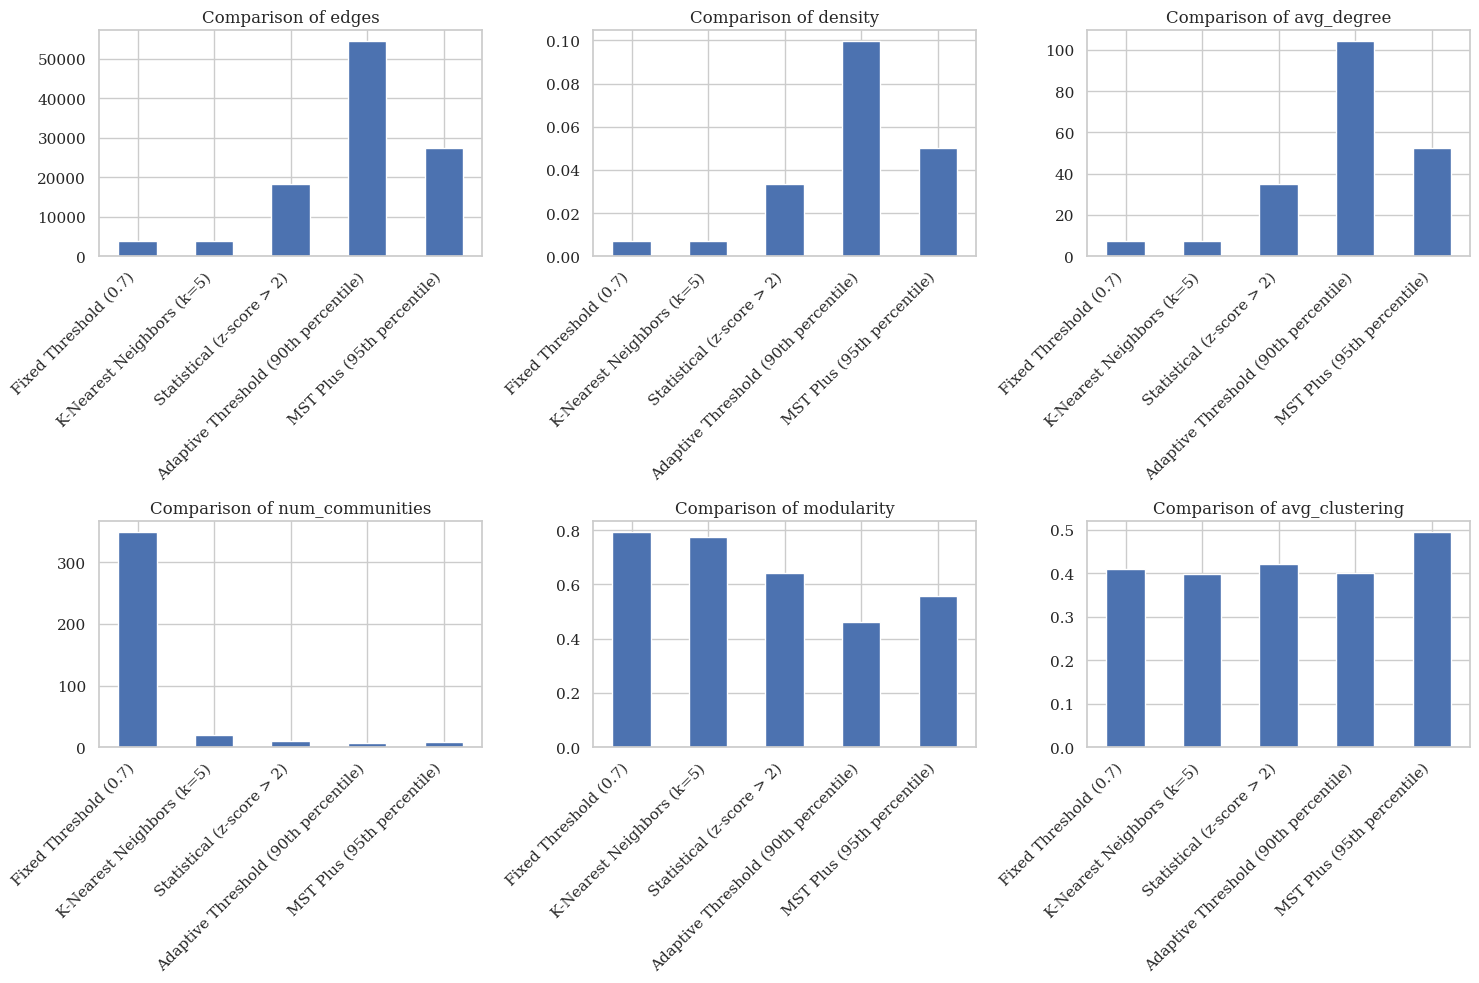

In [47]:
# Import additional required libraries
import pandas as pd
import numpy as np
import networkx as nx
from scipy import stats


def create_network_knn(similarity_df, k=5):
    """
    Creates a network where each professor is connected to their k most similar colleagues.
    """
    G = nx.Graph()
    professors = similarity_df.columns[1:]  # Skip 'Unnamed: 0'
    G.add_nodes_from(professors)

    # Process each professor
    for prof1 in professors:
        # Get similarities to all other professors
        similarities = similarity_df.loc[
            similarity_df["Unnamed: 0"] == prof1, professors
        ].values[0]
        # Get indices of k highest similarities (excluding self)
        prof_index = list(professors).index(prof1)
        similarities[prof_index] = -1  # Exclude self from consideration
        top_k_indices = np.argpartition(similarities, -k)[-k:]

        # Add edges to k most similar professors
        for idx in top_k_indices:
            if similarities[idx] > -1:  # Check we're not using the self-connection
                prof2 = professors[idx]
                G.add_edge(prof1, prof2, weight=similarities[idx])

    return G


def create_network_statistical(similarity_df, zscore_threshold=2.0):
    """
    Creates a network where edges exist between professors whose similarity
    is statistically significant based on z-scores.
    """
    G = nx.Graph()
    professors = similarity_df.columns[1:]
    G.add_nodes_from(professors)

    # Calculate z-scores for each professor's similarities
    for i, prof1 in enumerate(professors):
        similarities = similarity_df.loc[
            similarity_df["Unnamed: 0"] == prof1, professors
        ].values[0]
        zscore = stats.zscore(similarities)

        # Add edges where z-score exceeds threshold
        for j, (prof2, z) in enumerate(zip(professors, zscore)):
            if i < j and z > zscore_threshold:  # Only process each pair once
                similarity = similarities[j]
                G.add_edge(prof1, prof2, weight=similarity)

    return G


def create_network_adaptive_threshold(similarity_df, percentile=90):
    """
    Creates a network where the similarity threshold is set adaptively
    based on the distribution of similarities for each professor.
    """
    G = nx.Graph()
    professors = similarity_df.columns[1:]
    G.add_nodes_from(professors)

    for i, prof1 in enumerate(professors):
        similarities = similarity_df.loc[
            similarity_df["Unnamed: 0"] == prof1, professors
        ].values[0]
        threshold = np.percentile(similarities, percentile)

        # Add edges where similarity exceeds the adaptive threshold
        for j, (prof2, sim) in enumerate(zip(professors, similarities)):
            if i < j and sim > threshold:
                G.add_edge(prof1, prof2, weight=sim)

    return G


def create_network_mst_plus(similarity_df, extra_edges_percentile=95):
    """
    Creates a network based on the minimum spanning tree plus additional
    high-similarity edges to ensure connectivity while preserving strong links.
    """
    G = nx.Graph()
    professors = similarity_df.columns[1:]
    G.add_nodes_from(professors)

    # Create complete graph with similarities as weights
    complete_G = nx.Graph()
    for i, prof1 in enumerate(professors):
        for j, prof2 in enumerate(professors[i + 1 :], i + 1):
            similarity = similarity_df.loc[
                similarity_df["Unnamed: 0"] == prof1, prof2
            ].values[0]
            complete_G.add_edge(
                prof1, prof2, weight=1 - similarity
            )  # Convert to distance

    # Get minimum spanning tree
    mst = nx.minimum_spanning_tree(complete_G)

    # Add MST edges to final graph (converting back to similarities)
    for edge in mst.edges(data=True):
        G.add_edge(edge[0], edge[1], weight=1 - edge[2]["weight"])

    # Add additional high-similarity edges
    all_similarities = [
        similarity_df.loc[similarity_df["Unnamed: 0"] == prof1, prof2].values[0]
        for i, prof1 in enumerate(professors)
        for prof2 in professors[i + 1 :]
    ]
    threshold = np.percentile(all_similarities, extra_edges_percentile)

    for i, prof1 in enumerate(professors):
        for j, prof2 in enumerate(professors[i + 1 :], i + 1):
            if not G.has_edge(prof1, prof2):
                similarity = similarity_df.loc[
                    similarity_df["Unnamed: 0"] == prof1, prof2
                ].values[0]
                if similarity > threshold:
                    G.add_edge(prof1, prof2, weight=similarity)

    return G


def compare_networks(similarity_df):
    """
    Creates and compares networks using different construction methods.
    Returns statistics for each method.
    """
    methods = {
        "Fixed Threshold (0.7)": lambda: create_similarity_network(similarity_df, 0.7),
        "K-Nearest Neighbors (k=5)": lambda: create_network_knn(similarity_df, k=5),
        "Statistical (z-score > 2)": lambda: create_network_statistical(
            similarity_df, zscore_threshold=2.0
        ),
        "Adaptive Threshold (90th percentile)": lambda: create_network_adaptive_threshold(
            similarity_df, percentile=90
        ),
        "MST Plus (95th percentile)": lambda: create_network_mst_plus(
            similarity_df, extra_edges_percentile=95
        ),
    }

    results = {}
    for name, method in methods.items():
        print(f"Creating network using {name}...")
        G = method()
        communities = community_louvain.best_partition(G)

        results[name] = {
            "nodes": G.number_of_nodes(),
            "edges": G.number_of_edges(),
            "density": nx.density(G),
            "avg_degree": np.mean([d for n, d in G.degree()]),
            "num_components": nx.number_connected_components(G),
            "num_communities": len(set(communities.values())),
            "modularity": community_louvain.modularity(communities, G),
            "avg_clustering": nx.average_clustering(G),
        }

    return pd.DataFrame(results).T


# Compare the different methods
comparison_df = compare_networks(data)
print("\nComparison of Network Construction Methods:")
print(comparison_df)

# Visualize comparison
plt.figure(figsize=(15, 10))
metrics = [
    "edges",
    "density",
    "avg_degree",
    "num_communities",
    "modularity",
    "avg_clustering",
]
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    comparison_df[metric].plot(kind="bar")
    plt.title(f"Comparison of {metric}")
    plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Full Network Analysis

In [48]:
# Create the network
G = create_network_knn(data, k=5)

# Print basic network statistics
print(f"Network Statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.3f}")

Network Statistics:
Number of nodes: 1046
Number of edges: 3856
Network density: 0.007


## Community Detection

In [49]:
# Perform community detection
communities = community_louvain.best_partition(G)
num_communities = len(set(communities.values()))
print(f"\nNumber of communities detected: {num_communities}")

# Calculate and display community sizes
community_sizes = Counter(communities.values())
print("\nCommunity sizes:")
for community_id, size in sorted(community_sizes.items()):
    print(f"Community {community_id}: {size} members")


Number of communities detected: 19

Community sizes:
Community 0: 46 members
Community 1: 50 members
Community 2: 11 members
Community 3: 23 members
Community 4: 61 members
Community 5: 61 members
Community 6: 33 members
Community 7: 63 members
Community 8: 49 members
Community 9: 91 members
Community 10: 48 members
Community 11: 74 members
Community 12: 114 members
Community 13: 61 members
Community 14: 6 members
Community 15: 93 members
Community 16: 18 members
Community 17: 81 members
Community 18: 63 members


## Network Visualization

100%|██████████| 2000/2000 [00:12<00:00, 165.84it/s]


BarnesHut Approximation  took  2.84  seconds
Repulsion forces  took  8.07  seconds
Gravitational forces  took  0.12  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.58  seconds


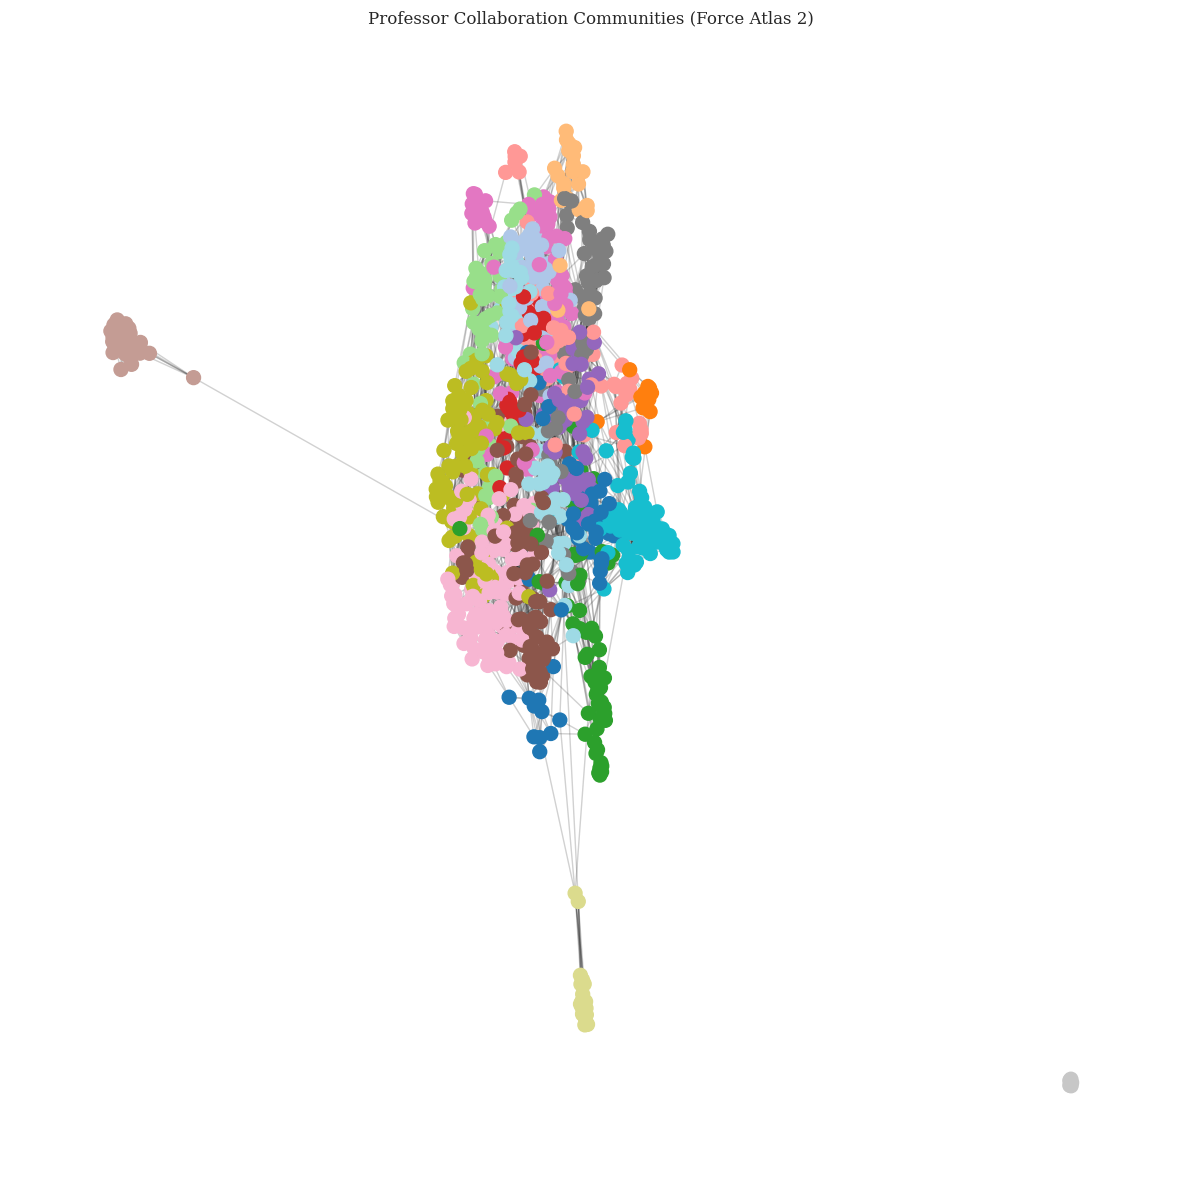

In [50]:
from fa2_modified import ForceAtlas2

# Initialize the ForceAtlas2 layout
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1.0,
    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED
    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,
    # Log
    verbose=True,
)

# Convert networkx graph to position dict
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

# Create visualization
plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(
    G,
    positions,
    node_color=list(communities.values()),
    cmap=plt.cm.tab20,
    node_size=100,
)
nx.draw_networkx_edges(G, positions, alpha=0.2)
plt.title("Professor Collaboration Communities (Force Atlas 2)")
plt.axis("off")
plt.show()

## Institute-Based Analysis

In [51]:
# Analyze communities within each institute

# Get primary institute for each professor
prof_institutes = get_professor_institutes(course_data)

# Create separate networks for each institute
institutes = set(prof_institutes.values())
institute_networks = {}
institute_communities = {}

for institute in institutes:
    # Get professors from this institute
    institute_profs = [
        prof for prof, inst in prof_institutes.items() if inst == institute
    ]

    # Create subgraph for this institute
    institute_subgraph = G.subgraph(institute_profs)
    institute_networks[institute] = institute_subgraph

    # Detect communities within this institute
    if institute_subgraph.number_of_nodes() > 0:
        institute_communities[institute] = community_louvain.best_partition(
            institute_subgraph
        )

## Institute Statistics

In [52]:
# Create a list to store the analysis data
institute_analysis = []

# Perform the analysis and store the results in the list
for institute in institutes:
    if institute in institute_networks:
        G_inst = institute_networks[institute]
        num_communities = (
            len(set(institute_communities[institute].values()))
            if institute in institute_communities
            else 0
        )
        institute_analysis.append(
            {
                "Institute": institute,
                "Number of Professors": G_inst.number_of_nodes(),
                "Number of Connections": G_inst.number_of_edges(),
                "Number of Communities": num_communities,
            }
        )

# Convert the list to a pandas DataFrame
institute_analysis_df = pd.DataFrame(institute_analysis)

# Display the DataFrame
print("\nInstitute-wise Community Analysis:")
institute_analysis_df.head()


Institute-wise Community Analysis:


Institute  Number of Professors  Number of Connections  \
0  Energy Conversion and Storage                    35                     71   
1                    Wind Energy                    81                    201   
2          Photonics Engineering                    70                    117   
3              Health Technology                    64                     84   
4       Management and Economics                    68                     82   

   Number of Communities  
0                     10  
1                     14  
2                     17  
3                     17  
4                     24

## Institute Network Visualization


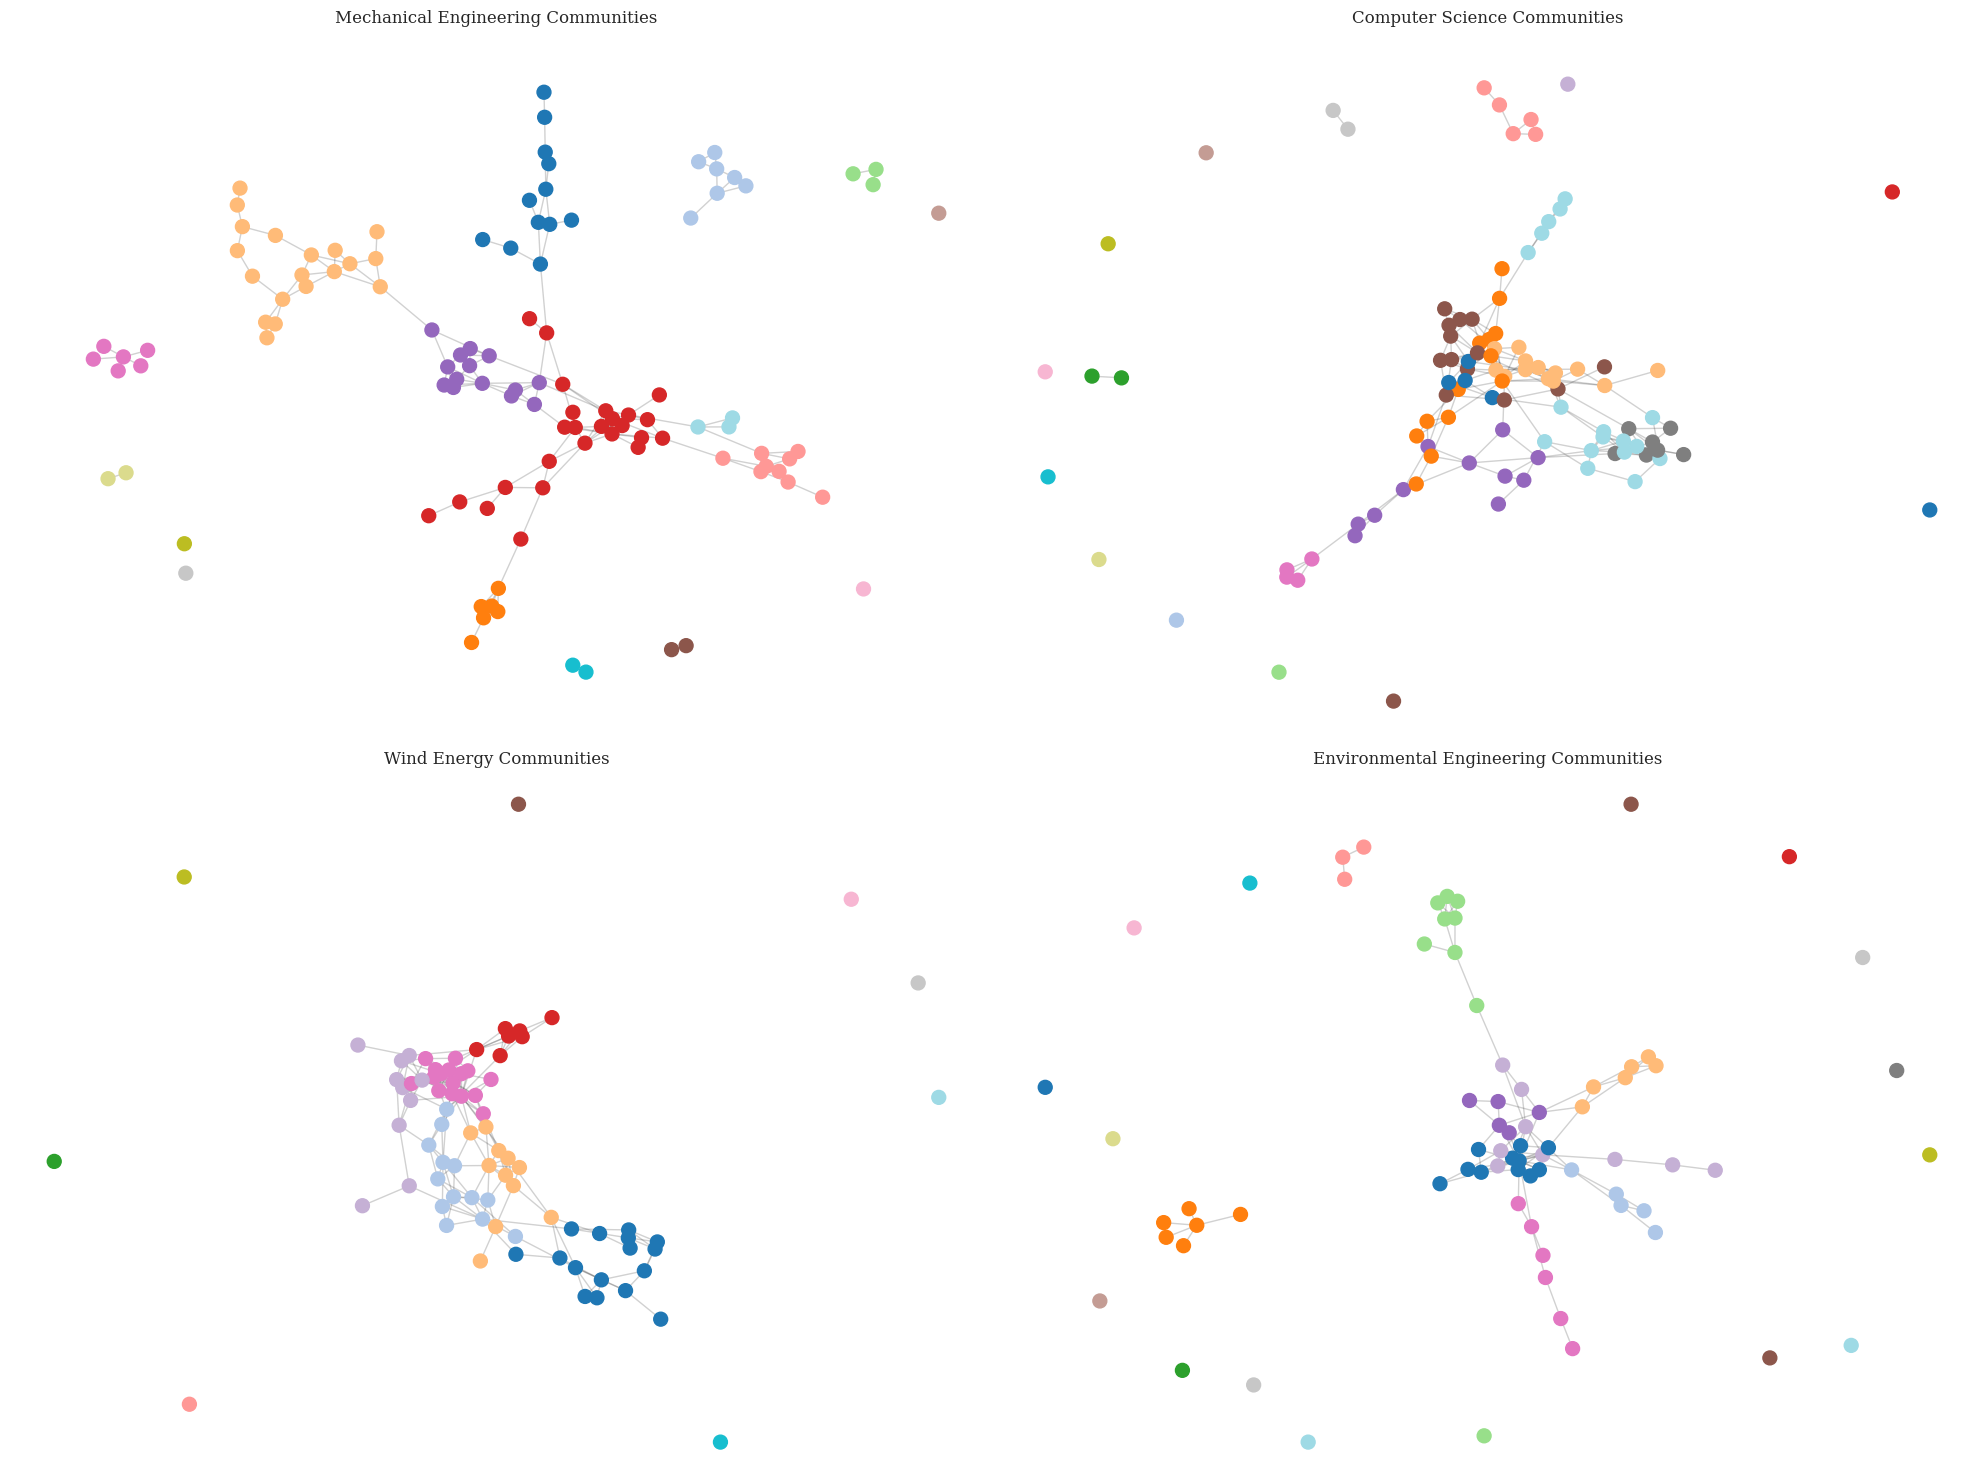

In [53]:
# Visualize the networks of the 4 largest institutes

largest_institutes = sorted(
    [(inst, G_inst.number_of_nodes()) for inst, G_inst in institute_networks.items()],
    key=lambda x: x[1],
    reverse=True,
)[:4]

plt.figure(figsize=(20, 15))
for idx, (institute, _) in enumerate(largest_institutes, 1):
    plt.subplot(2, 2, idx)
    G_inst = institute_networks[institute]
    if institute in institute_communities:
        colors = list(institute_communities[institute].values())
    else:
        colors = "b"

    pos = nx.spring_layout(G_inst, k=1 / np.sqrt(G_inst.number_of_nodes()), seed=42)
    nx.draw_networkx_nodes(
        G_inst, pos, node_color=colors, cmap=plt.cm.tab20, node_size=100
    )
    nx.draw_networkx_edges(G_inst, pos, alpha=0.2)
    plt.title(f"{institute} Communities")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Cross-Institute Connections Analysis

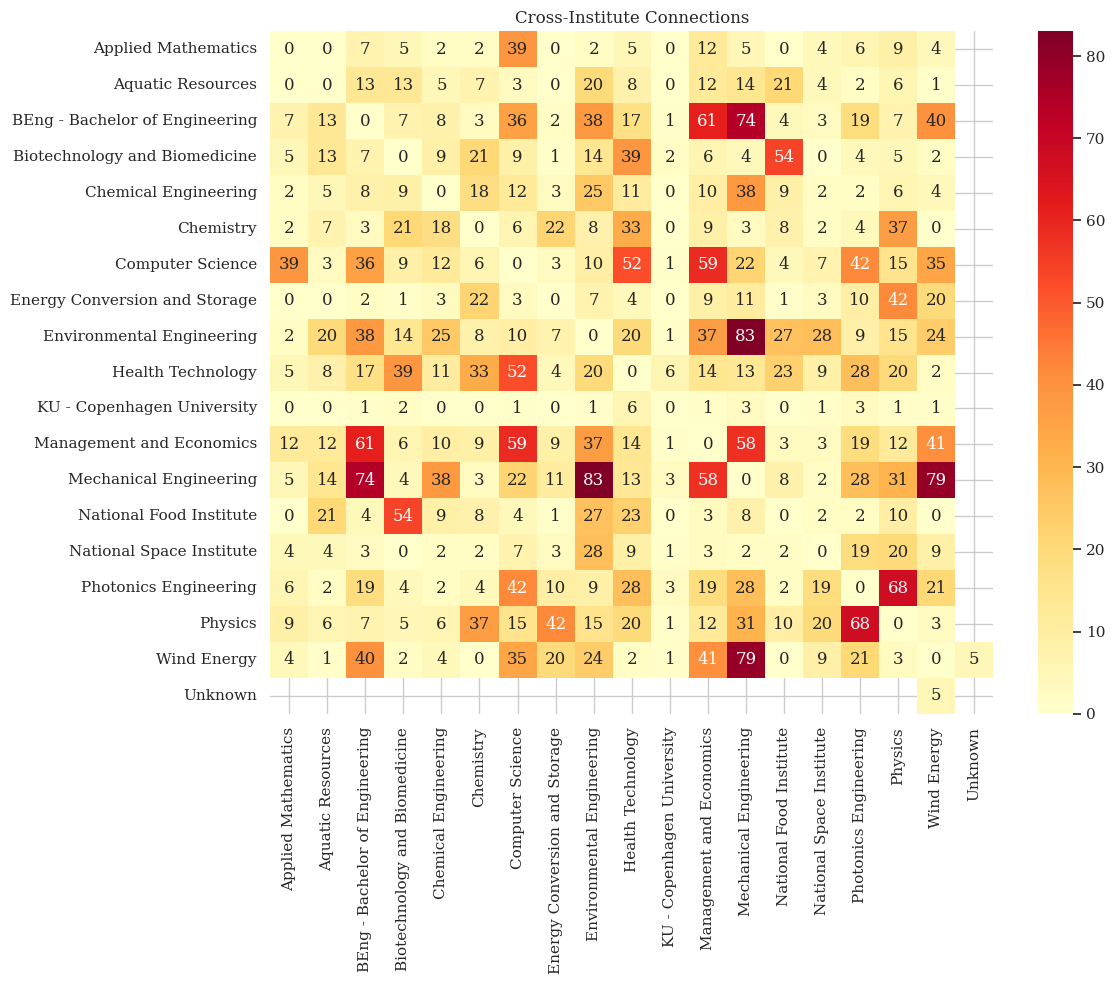

In [54]:
# Calculate cross-institute connections
cross_institute_connections = {}
for prof1, prof2 in G.edges():
    inst1 = prof_institutes.get(prof1, "Unknown")
    inst2 = prof_institutes.get(prof2, "Unknown")
    if inst1 != inst2:
        pair = tuple(sorted([inst1, inst2]))
        cross_institute_connections[pair] = cross_institute_connections.get(pair, 0) + 1

# Create cross-institute connection matrix
unique_institutes = sorted(list(institutes))
connection_matrix = pd.DataFrame(0, index=unique_institutes, columns=unique_institutes)

for (inst1, inst2), count in cross_institute_connections.items():
    connection_matrix.loc[inst1, inst2] = count
    connection_matrix.loc[inst2, inst1] = count

# Visualize cross-institute connections
plt.figure(figsize=(12, 10))
sns.heatmap(connection_matrix, annot=True, cmap="YlOrRd", fmt="g")
plt.title("Cross-Institute Connections")
plt.tight_layout()
plt.show()

In [55]:
# Get top cross-institute connections
def analyze_cross_connections(connection_matrix):
    # Create a DataFrame for pairs of institutes and their connection counts
    pairs = []
    for i in connection_matrix.index:
        for j in connection_matrix.columns:
            if i < j:  # Avoid duplicates
                pairs.append(
                    {
                        "institute1": i,
                        "institute2": j,
                        "connections": connection_matrix.loc[i, j],
                    }
                )

    pairs_df = pd.DataFrame(pairs)
    # Sort by number of connections
    return pairs_df.sort_values("connections", ascending=False)


# Get top 10 strongest connections
top_connections = analyze_cross_connections(connection_matrix).head(10)
print("Top 10 Cross-Institute Collaborations:")
print(top_connections)

Top 10 Cross-Institute Collaborations:
                         institute1                institute2  connections
119       Environmental Engineering    Mechanical Engineering         83.0
154          Mechanical Engineering               Wind Energy         79.0
44   BEng - Bachelor of Engineering    Mechanical Engineering         74.0
165           Photonics Engineering                   Physics         68.0
43   BEng - Bachelor of Engineering  Management and Economics         61.0
97                 Computer Science  Management and Economics         59.0
143        Management and Economics    Mechanical Engineering         58.0
60    Biotechnology and Biomedicine   National Food Institute         54.0
95                 Computer Science         Health Technology         52.0
101                Computer Science     Photonics Engineering         42.0


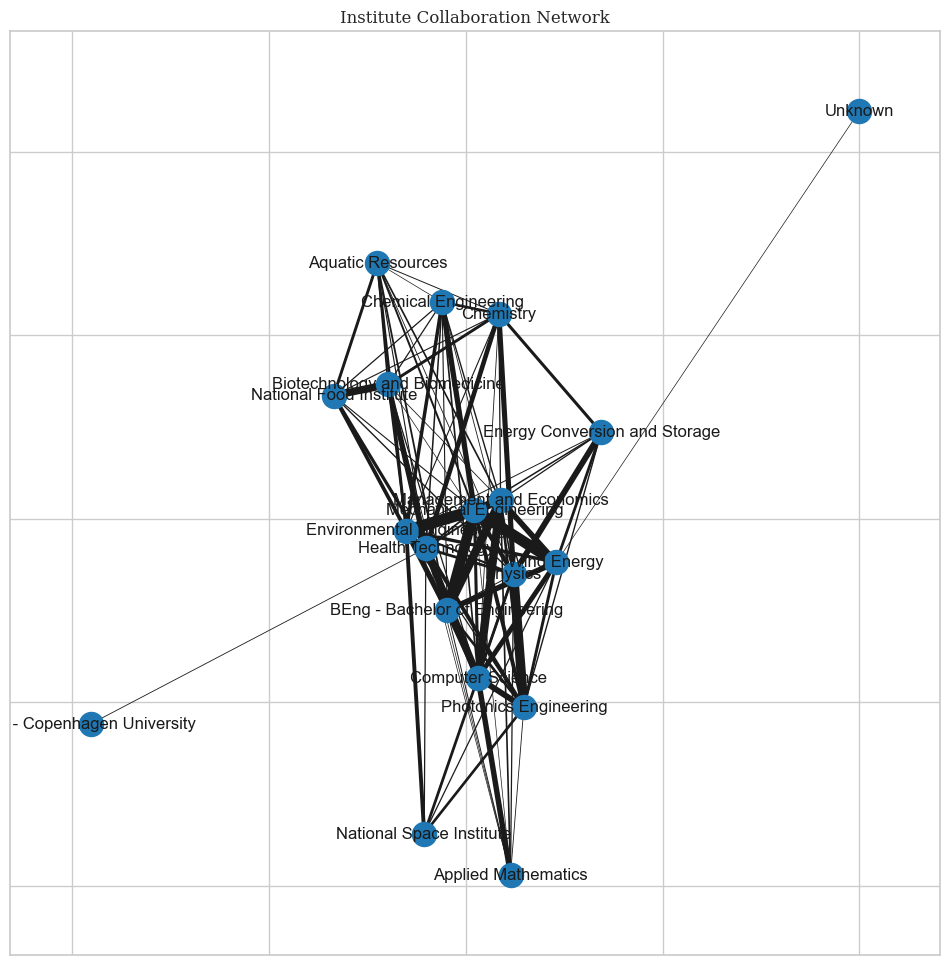

In [56]:
# Create a network of institutes
def create_institute_network(connection_matrix, min_connections=5):
    G = nx.Graph()

    # Add nodes (institutes)
    G.add_nodes_from(connection_matrix.index)

    # Add edges where connections exceed threshold
    for i in connection_matrix.index:
        for j in connection_matrix.columns:
            if i < j and connection_matrix.loc[i, j] >= min_connections:
                G.add_edge(i, j, weight=connection_matrix.loc[i, j])

    return G


# Visualize institute network
G_inst = create_institute_network(connection_matrix)
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_inst)
nx.draw_networkx_nodes(G_inst, pos)
nx.draw_networkx_edges(
    G_inst, pos, width=[G_inst[u][v]["weight"] / 10 for u, v in G_inst.edges()]
)
nx.draw_networkx_labels(G_inst, pos)
plt.title("Institute Collaboration Network")
plt.show()

In [60]:
def analyze_institute_collaboration(connection_matrix):
    metrics = {}

    for institute in connection_matrix.index:
        metrics[institute] = {
            "total_external_connections": connection_matrix.loc[institute].sum(),
            "num_collaborating_institutes": (
                connection_matrix.loc[institute] > 0
            ).sum(),
            "strongest_partner": connection_matrix.loc[institute].idxmax(),
            "max_connections": connection_matrix.loc[institute].max(),
        }

    return pd.DataFrame(metrics).T.sort_values(
        "total_external_connections", ascending=False
    )


institute_metrics = analyze_institute_collaboration(connection_matrix)
print("\nInstitute Collaboration Metrics:")
institute_metrics.head()


Institute Collaboration Metrics:


total_external_connections  \
Mechanical Engineering                              476.0   
Environmental Engineering                           368.0   
Management and Economics                            366.0   
Computer Science                                    355.0   
BEng - Bachelor of Engineering                      340.0   

                               num_collaborating_institutes  \
Mechanical Engineering                                   17   
Environmental Engineering                                17   
Management and Economics                                 17   
Computer Science                                         17   
BEng - Bachelor of Engineering                           17   

                                             strongest_partner max_connections  
Mechanical Engineering               Environmental Engineering            83.0  
Environmental Engineering               Mechanical Engineering            83.0  
Management and Economics        BEng - Bachelor of Engineering            61.0  
Computer Science                      Management and Economics            59.0  
BEng - Bachelor of Engineering          Mechanical Engineering            74.0

In [58]:
# Use community detection on the institute network
def find_institute_clusters(connection_matrix, min_connections=5):
    G_inst = create_institute_network(connection_matrix, min_connections)
    communities = community_louvain.best_partition(G_inst)

    # Group institutes by community
    clusters = {}
    for institute, community_id in communities.items():
        if community_id not in clusters:
            clusters[community_id] = []
        clusters[community_id].append(institute)

    return clusters


institute_clusters = find_institute_clusters(connection_matrix)
print("\nInstitute Collaboration Clusters:")
for cluster_id, institutes in institute_clusters.items():
    print(f"\nCluster {cluster_id}:")
    print(institutes)


Institute Collaboration Clusters:

Cluster 1:
['Applied Mathematics', 'Computer Science']

Cluster 3:
['Aquatic Resources', 'Biotechnology and Biomedicine', 'Chemical Engineering', 'Chemistry', 'Health Technology', 'KU - Copenhagen University', 'National Food Institute']

Cluster 0:
['BEng - Bachelor of Engineering', 'Environmental Engineering', 'Management and Economics', 'Mechanical Engineering', 'Wind Energy', 'Unknown']

Cluster 2:
['Energy Conversion and Storage', 'National Space Institute', 'Photonics Engineering', 'Physics']


In [59]:
def calculate_collaboration_diversity(connection_matrix):
    diversity = {}

    for institute in connection_matrix.index:
        connections = connection_matrix.loc[institute]
        total = connections.sum()
        if total > 0:
            proportions = connections / total
            # Calculate Shannon diversity index
            shannon_diversity = -sum(p * np.log(p) for p in proportions if p > 0)
            diversity[institute] = shannon_diversity

    return pd.Series(diversity).sort_values(ascending=False)


collaboration_diversity = calculate_collaboration_diversity(connection_matrix)
print("\nCollaboration Diversity Index by Institute:")
print(collaboration_diversity)


Collaboration Diversity Index by Institute:
Health Technology                 2.572462
Environmental Engineering         2.512780
Physics                           2.456091
Computer Science                  2.443677
Chemical Engineering              2.429551
Management and Economics          2.419109
Aquatic Resources                 2.405658
Photonics Engineering             2.388941
Mechanical Engineering            2.369584
Chemistry                         2.339099
National Space Institute          2.322759
BEng - Bachelor of Engineering    2.321503
Biotechnology and Biomedicine     2.265874
Wind Energy                       2.186935
KU - Copenhagen University        2.152688
Energy Conversion and Storage     2.140893
National Food Institute           2.138241
Applied Mathematics               2.112860
Unknown                          -0.000000
dtype: float64


## Results

## Conclusion

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=74b4f0fb-fa83-4566-a475-d62df4912ba3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>